```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018, 2019 Norwegian Meteorological Institute

This notebook implements the experiments to evaluate convergence rates
for the four numerical schemes, as reported in Section 4.7 in 
"Evaluation of Selected Finite-Difference and Finite-Volume Approaches
to Rotational Shallow-Water Flow"  by Holm, Brodtkorb, Broström, 
Christensen and Sætra. 

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Numerical Order

This notebook runs an experiment to evaluate the numerical order for each of the four schemes. By running this notebook, the convergence plots presented in Section 4.7 "Numerical Order" in the paper should be reproduced.



## Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import os
import datetime
import gc
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(6.0, 4.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import FBL, CTCS,KP07, CDKLM16, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
%setup_logging -o compareschemes2d.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger using level DEBUG to compareschemes2d.log
Python version 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:53:17) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Registering gpu_ctx in user workspace
PyCUDA version 2018.1.1
CUDA version (10, 0, 0)
Driver version 10000
Using 'GeForce GTX 780' GPU
Created context handle <37301104>


In [3]:
#Create output directory for images
imgdir='images_convergence_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print("Saving images to " + imgdir)

Saving images to images_convergence_2019_02_07-16_41_32


In [4]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

In [5]:
width = 100
height = 100

domain_min = 16
domain_max = 768
    
g = 9.81
r = 0.0
f = 0.01

end_time = 5.0

In [6]:
def averageFV(highres_solution, factor):
    NX = highres_solution.shape[1]
    NY = highres_solution.shape[0]
    
    assert(NY % factor == 0)
    assert(NX % factor == 0)
    
    nx = int(NX / factor)
    ny = int(NY / factor)
    
    factor = int(factor)
    
    return  highres_solution.reshape([ny, factor, nx, factor]).mean(3).mean(1)

def averageFD(highres_solution, factor):
    target = highres_solution.shape[0] / factor
    while (highres_solution.shape[0] > target):
        highres_solution = highres_solution[::2, ::2]
    return highres_solution

Finite volume
FV: Max=0.00093, min=0.00000, sum=0.0000840759
FV: Max=0.00098, min=0.00000, sum=0.0000840759
FV: Max=0.00100, min=0.00000, sum=0.0000840759
FV: Max=0.00100, min=0.00000, sum=0.0000840759
FV: Max=0.00100, min=0.00000, sum=0.0000840759
Finite difference
FD: Max=0.01000, min=0.00000, sum=0.0007320320
FD: Max=0.01000, min=0.00000, sum=0.0007837343
FD: Max=0.01000, min=0.00000, sum=0.0008115245
FD: Max=0.01000, min=0.00000, sum=0.0008259438
FD: Max=0.01000, min=0.00000, sum=0.0008333020


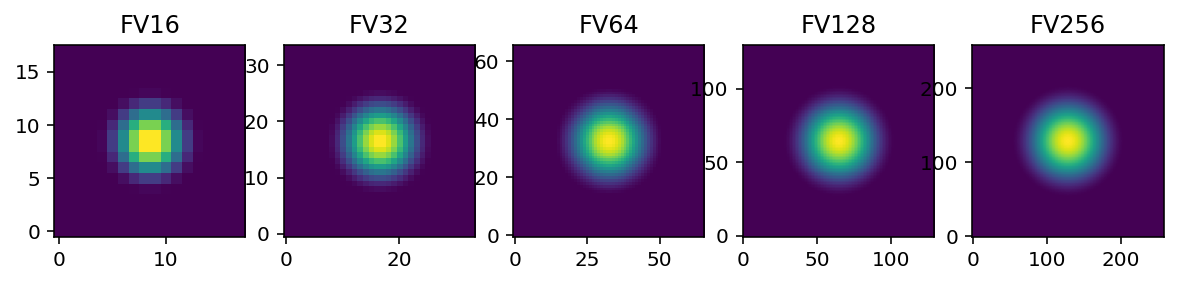

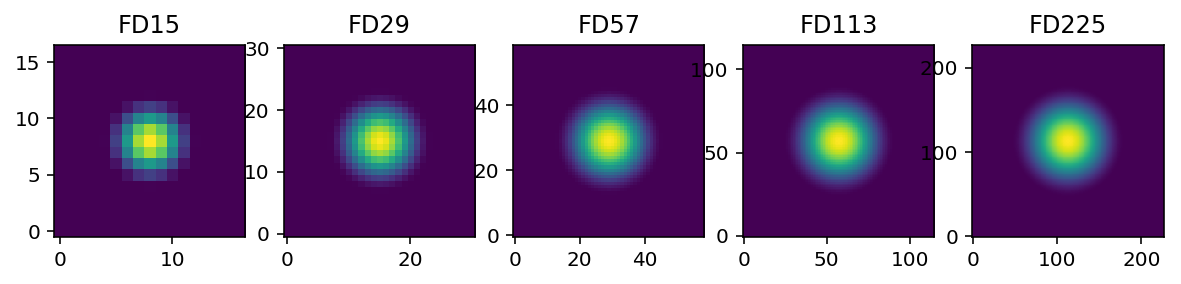

In [7]:
def initH(h0, ghosts):    
    waterHeight = 0.5
    h0.fill(waterHeight)
    
def initEtaFV(eta0, ghosts, reference_domain_size):
    ref_nx = reference_domain_size
    ref_ny = reference_domain_size
    nx = eta0.shape[1] - ghosts[0] - ghosts[2]
    ny = eta0.shape[0] - ghosts[1] - ghosts[3]
    
    def my_cos(i, j):
        size = 0.6
        x = 2*(i + 0.5 - ref_nx/2.0) / float(ref_nx)
        y = 2*(j + 0.5 - ref_ny/2.0) / float(ref_ny)
        r = np.sqrt(x**2 + y**2)
        return 0.05*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    
    #Generate disturbance 
    disturbance = np.fromfunction(lambda i, j: my_cos(i,j), (ref_ny, ref_nx))
    disturbance = averageFV(disturbance, ref_nx/nx) 
    
    eta0.fill(0.0)
    x0, x1 = ghosts[0], nx+ghosts[0]
    y0, y1 = ghosts[1], ny+ghosts[1]
    eta0[y0:y1, x0:x1] += (0.01*disturbance)
    
    #Make sure solution is symmetric
    eta0 = 0.5*(eta0 +  eta0[::-1, ::-1])
    

def initEtaFD(eta0, ghosts):
    nx = eta0.shape[1] - ghosts[0] - ghosts[2]
    ny = eta0.shape[0] - ghosts[1] - ghosts[3]
    
    def my_cos(i, j):
        size = 0.6
        x = 2*(i - (nx-1)/2.0) / float(nx-1)
        y = 2*(j - (ny-1)/2.0) / float(ny-1)
        r = np.sqrt(x**2 + y**2)
        return 0.5*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    
    #Generate disturbance 
    disturbance = np.fromfunction(lambda i, j: my_cos(i,j), (ny, nx))
    
    eta0.fill(0.0)
    x0, x1 = ghosts[0], nx+ghosts[0]
    y0, y1 = ghosts[1], ny+ghosts[1]
    eta0[y0:y1, x0:x1] += (0.01*disturbance)
    
    #Make sure solution is symmetric
    eta0 = 0.5*(eta0 +  eta0[::-1, ::-1])
    
    
def initHU(hu0, ghosts):
    hu0.fill(0.0)
    
def initHV(hv0, ghosts):
    hv0.fill(0.0)

def testInitDataFV(domain_size, reference_domain_size):
    
    nx = domain_size
    ny = domain_size
    
    ghosts = [1, 1, 1, 1] 
    dataShape = (ny + ghosts[1]+ghosts[3], 
                 nx + ghosts[0]+ghosts[2])

    eta0 = np.zeros(dataShape, dtype=np.float32);
    
    initEtaFV(eta0, ghosts, reference_domain_size)
    
    return eta0#[ghosts[1]:eta0.shape[1]+ghosts[1], ghosts[0]:eta0.shape[0]+ghosts[0]]

def testInitDataFD(domain_size):
    nx = domain_size
    ny = domain_size
    
    ghosts = [1, 1, 1, 1] 
    dataShape = (ny + ghosts[1]+ghosts[3], 
                 nx + ghosts[0]+ghosts[2])

    eta0 = np.zeros(dataShape, dtype=np.float32);
    
    initEtaFD(eta0, ghosts)
    
    return eta0#[ghosts[1]:eta0.shape[1]+ghosts[1], ghosts[0]:eta0.shape[0]+ghosts[0]]
    
plt.figure(figsize=(12,8))
print("Finite volume")
for i in range(5):
    domain_size = domain_min*2**i
    eta0 = testInitDataFV(domain_size, domain_min*2**6)
    plt.subplot(1, 6, i+1)
    plt.imshow(eta0, interpolation='nearest', origin='lower')
    plt.title("FV"+str(domain_size))
    print("FV: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta0), np.min(eta0), np.sum(eta0/(domain_size*domain_size))))
    
plt.figure(figsize=(12,8))
print("Finite difference")
domain_size = int(domain_min/2)
for i in range(5):
    domain_size = domain_size*2-1
    eta0 = testInitDataFD(domain_size)
    plt.subplot(1, 6, i+1)
    plt.imshow(eta0, interpolation='nearest', origin='lower')
    plt.title("FD"+str(domain_size))
    print("FD: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(eta0), np.min(eta0), np.sum(eta0/(domain_size*domain_size))))
    
    
def estimateDt(dx, dy, g):
    max_h_estimate = 0.5
    max_u_estimate = 0.25
    return min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))

In [8]:
def plotData(eta0, u0, v0, eta1, u1, v1):
    fig, axarr = plt.subplots(2, 3, figsize=(12, 8))
    axarr[0, 0].imshow(eta0, interpolation="nearest")
    axarr[0, 1].imshow(u0, interpolation="nearest")
    axarr[0, 2].imshow(v0, interpolation="nearest")
    axarr[1, 0].imshow(eta1, interpolation="nearest")
    axarr[1, 1].imshow(u1, interpolation="nearest")
    axarr[1, 2].imshow(v1, interpolation="nearest")
    print("Eta0: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta0), np.min(eta0)))
    print("Eta1: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta1), np.min(eta1)))

In [9]:
def plotError(eta, eta_ref):
    max_eta = max(eta.max(), eta_ref.max())
    min_eta = min(eta.min(), eta_ref.min())
    
    err = eta - eta_ref
    max_err = max(abs(err.max()), abs(err.min()))
    
    ax1 = plt.subplot(1,3,1)
    plt.imshow(eta, vmax=max_eta, vmin=min_eta)
    plt.colorbar(shrink=0.9)
    ax1.set_title("Eta")

    ax2 = plt.subplot(1,3,2)
    plt.imshow(eta_ref, vmax=max_eta, vmin=min_eta)
    plt.colorbar(shrink=0.9)
    ax2.set_title("Eta ref")

    ax3 = plt.subplot(1,3,3)
    plt.imshow(err, vmax=max_err, vmin=-max_err, cmap="bwr")
    plt.colorbar(shrink=0.9)
    ax3.set_title("Error")

In [10]:
def computeError(filename, downsampler, order=1, plot=False):
    error = None
    domain_sizes = None
    with np.load(filename) as npzfile:
        #Get all domain sizes in file
        domain_sizes = np.array(list(npzfile.keys()), dtype=np.int)
        error = np.zeros(len(domain_sizes)-1)

        #Get largest domain size and remove (reference domain size)
        reference_domain_size = np.max(domain_sizes)
        domain_sizes = np.delete(domain_sizes, np.where(domain_sizes == reference_domain_size))

        #Get reference
        eta1_ref_disk = npzfile[str(reference_domain_size)].astype(np.float64)

        #Loop over all other domain sizes and compute the error
        for l, domain_size in enumerate(domain_sizes):
            #Get simulation
            eta1 = npzfile[str(domain_size)].astype(np.float64)

            #Downsample reference to simulation size
            eta1_ref = downsampler(eta1_ref_disk.copy(), reference_domain_size/domain_size)
            
            if (plot==True):
                plt.figure(figsize=(16,4))#, dpi=300)
                plotError(eta1, eta1_ref)
                plt.suptitle(filename)

            #Compute error 
            area = 1.0 / (domain_size*domain_size)
            if (order == 1):
                error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=order) * area
            elif (order == 2):
                error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=order) * np.sqrt(area)
            elif (order == np.inf):
                error[l] = np.linalg.norm((eta1_ref - eta1).flatten(), ord=order) 
        
    return domain_sizes, error


## Forward Backward Linear

In [11]:
def benchmarkFBL(fbl_filename):
    def runFBL(domain_size):
        #Clean up old simulator if any:
        if 'fbl_sim' in globals():
            fbl_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/(nx-1))
        dy = float(height/(ny-1))

        ghosts = [1, 1, 1, 1]
        #ghosts = [0, 0, 0, 0]
        dataShape = (ny + ghosts[1]+ghosts[3], 
                     nx + ghosts[0]+ghosts[2])

        h0 = np.zeros(dataShape, dtype=np.float32);
        eta0 = np.zeros(dataShape, dtype=np.float32);
        hu0 = np.zeros((dataShape[0], dataShape[1]-1), dtype=np.float32);
        #hu0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
        hv0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);
        
        dt = 0.45 * estimateDt(dx, dy, g)
        initH(h0, ghosts)
        initEtaFD(eta0, ghosts)
        initHU(hu0, ghosts)
        initHV(hv0, ghosts)

        #Initialize simulator
        fbl_sim = FBL.FBL(gpu_ctx, \
                      h0, eta0, hu0, hv0, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r, block_width=16, block_height=16)

        t = fbl_sim.step(end_time)
        eta1, hu1, hv1 = fbl_sim.download(interior_domain_only=True)
        print("Domain size={:d}, dt={:f}, nt={}, eta=[{:f}, {:f}]".format(domain_size, dt, fbl_sim.num_iterations, np.min(eta1), np.max(eta1)))
        
        return [eta0, hu0, hv0, eta1, hu1, hv1]

    #Run all domain sizes 
    data = {};
    domain_size = domain_min-1
    while (domain_size < domain_max):
        [_, _, _, eta1, _, _] = runFBL(domain_size)
        data[str(domain_size)] = eta1
        domain_size = domain_size*2-1

    #Save to file
    np.savez_compressed(fbl_filename, **data)
    
fbl_filename = imgdir + "/FBL_data.npz"
benchmarkFBL(fbl_filename)

Domain size=15, dt=1.304116, nt=4, eta=[-0.000000, 0.003199]
Domain size=29, dt=0.652058, nt=8, eta=[-0.000000, 0.003652]
Domain size=57, dt=0.326029, nt=16, eta=[-0.000000, 0.003926]
Domain size=113, dt=0.163015, nt=31, eta=[-0.000000, 0.004074]
Domain size=225, dt=0.081507, nt=62, eta=[0.000000, 0.004151]
Domain size=449, dt=0.040754, nt=123, eta=[0.000000, 0.004190]


(13.100464545240449,
 257.6244520448075,
 3.3319878350807596e-06,
 0.00010615646991998051)

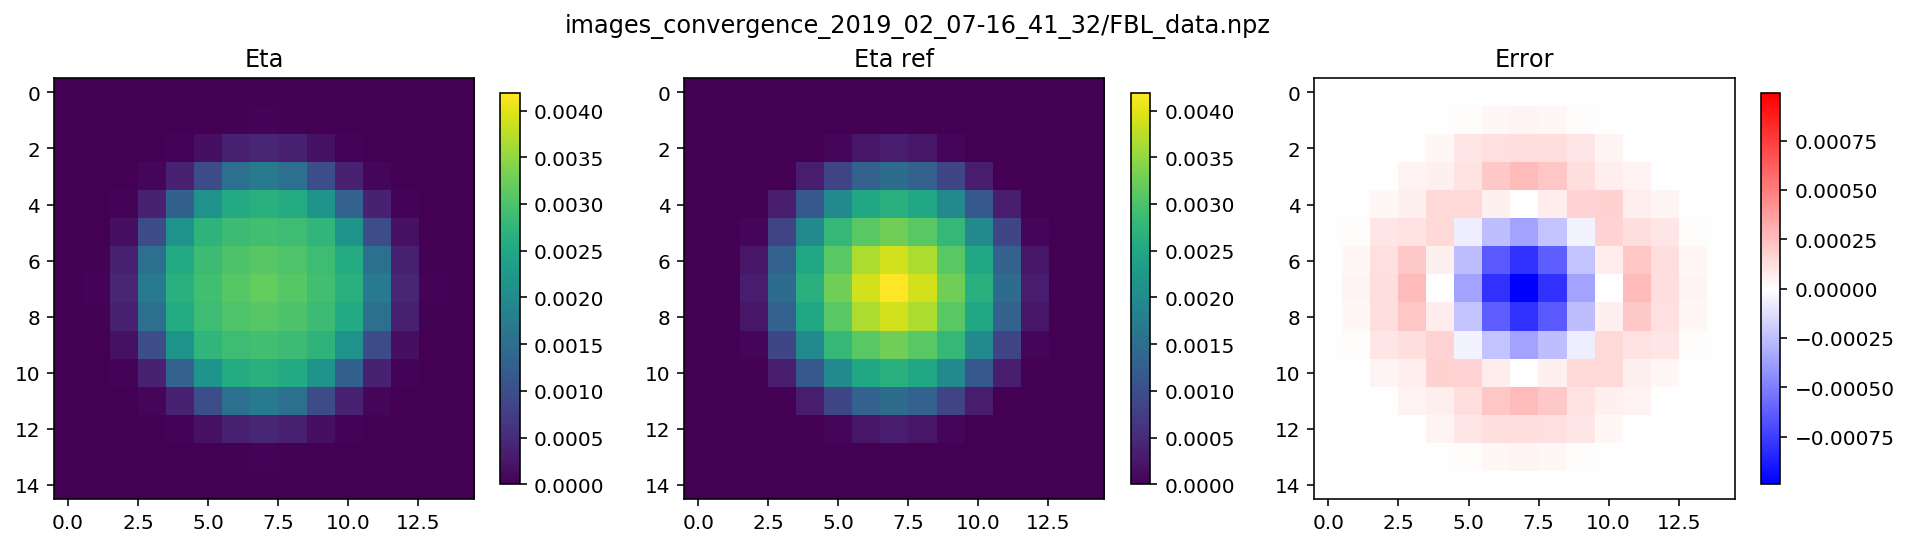

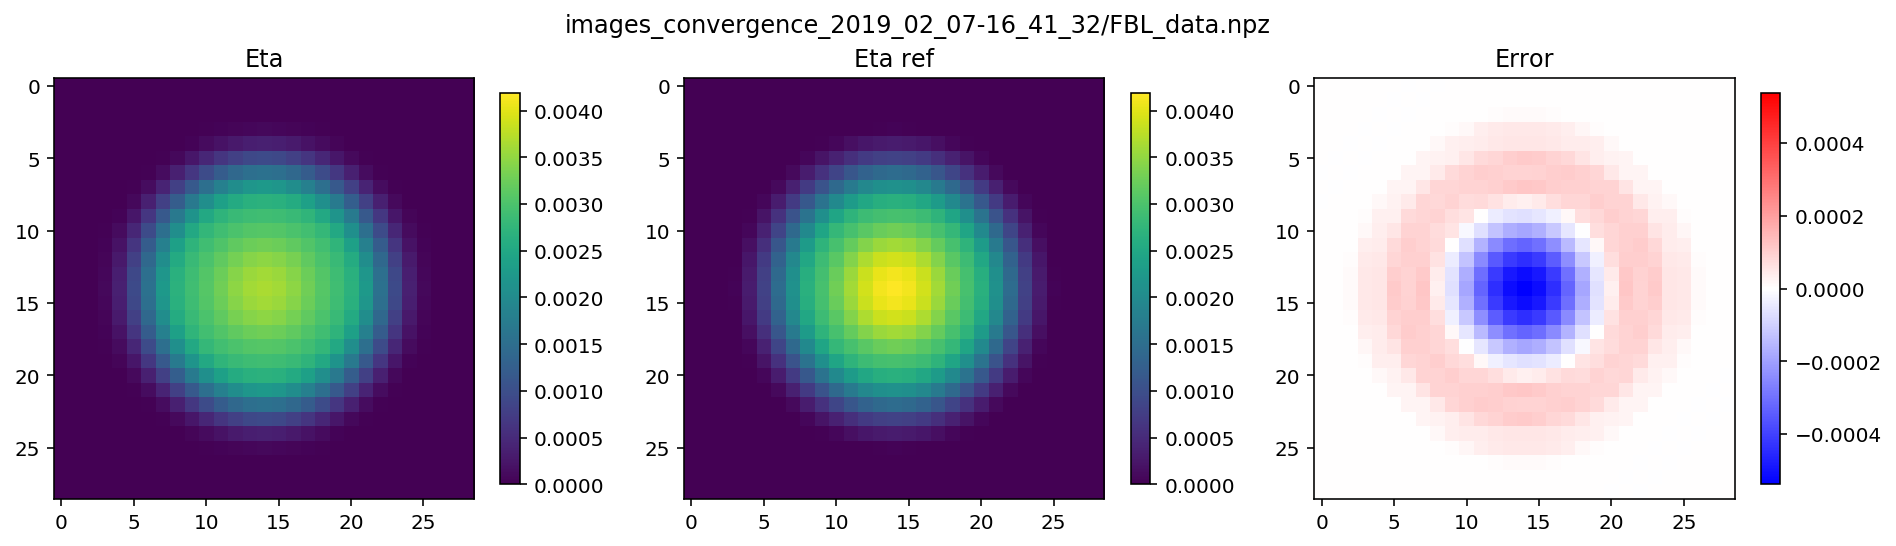

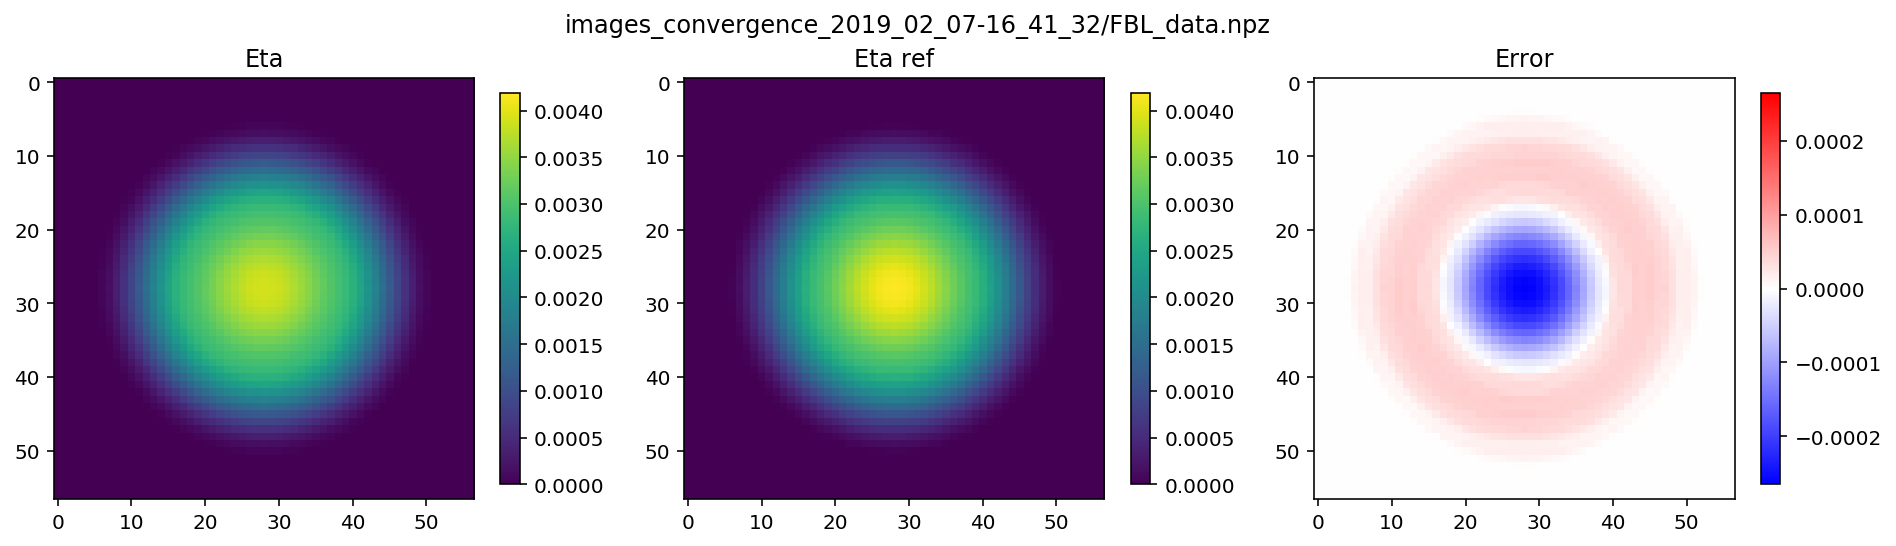

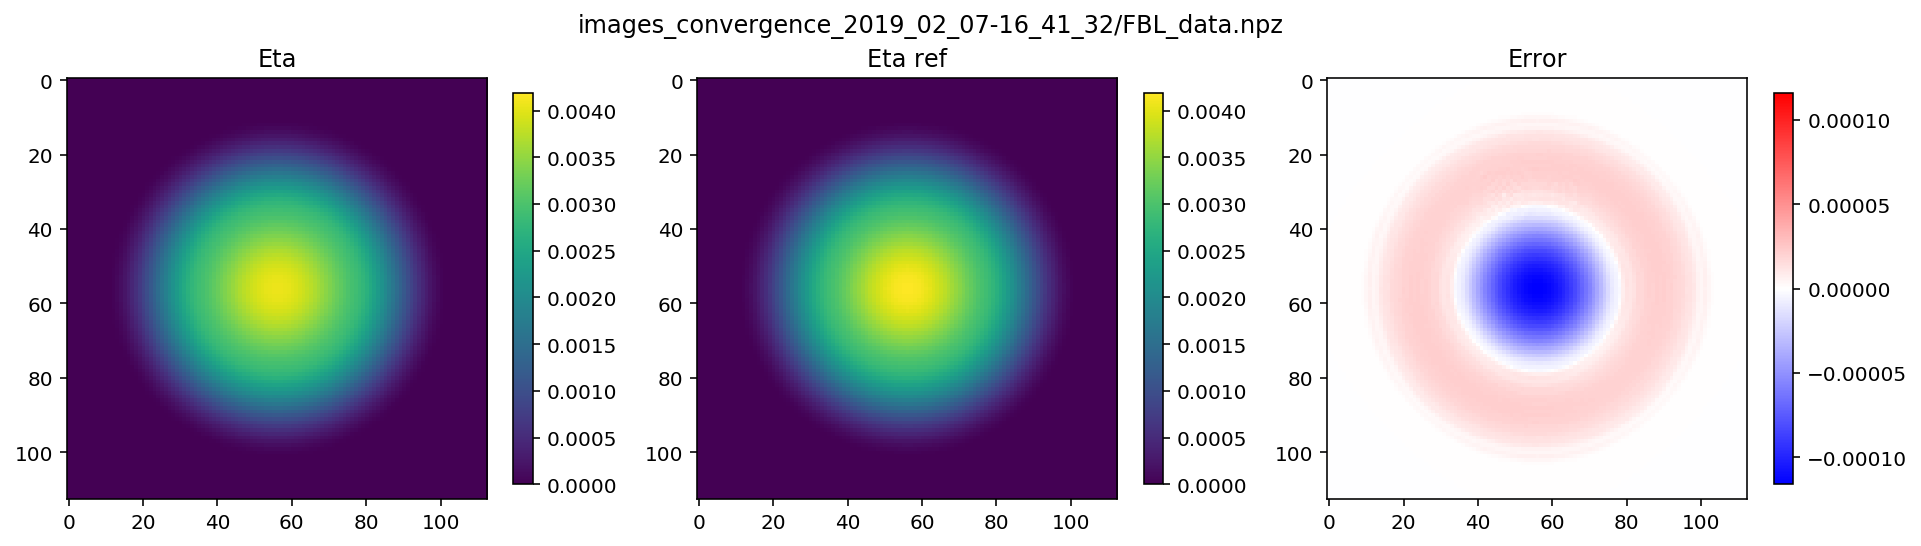

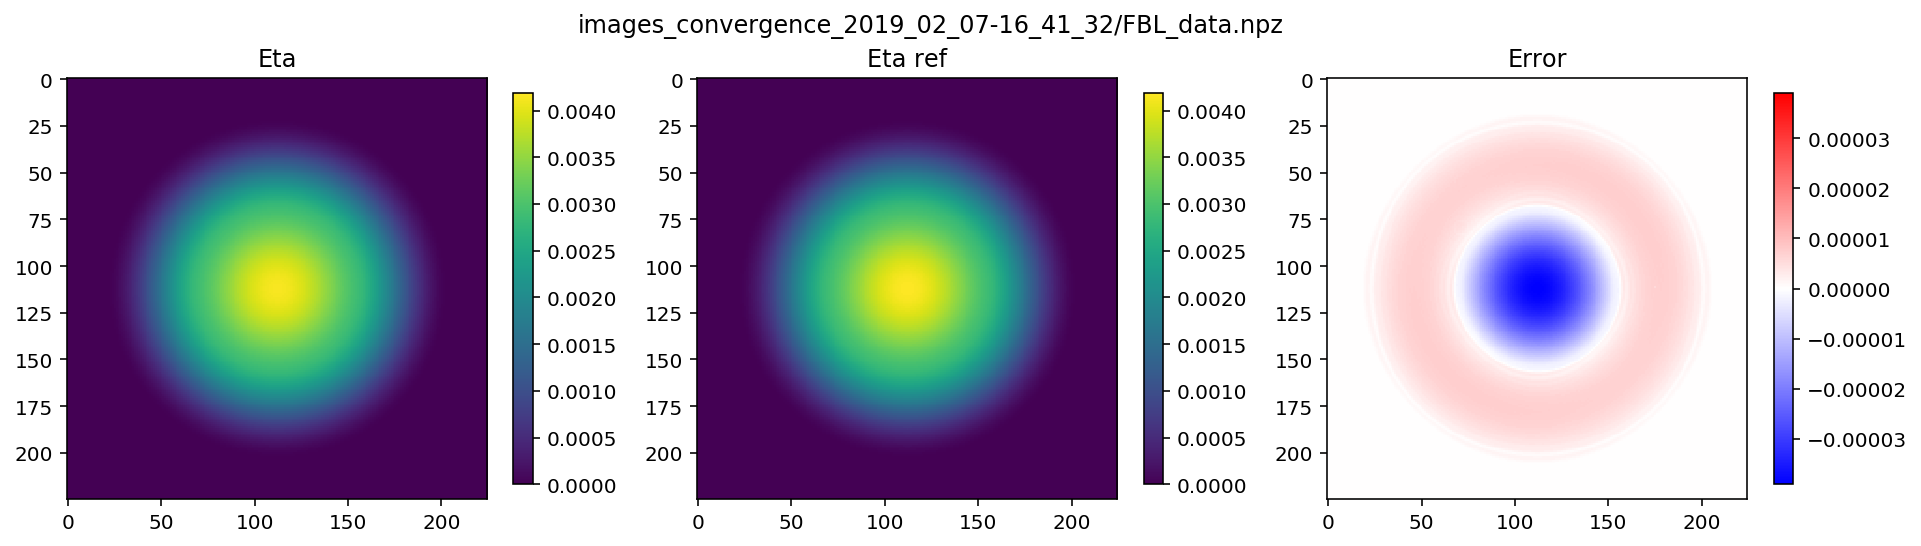

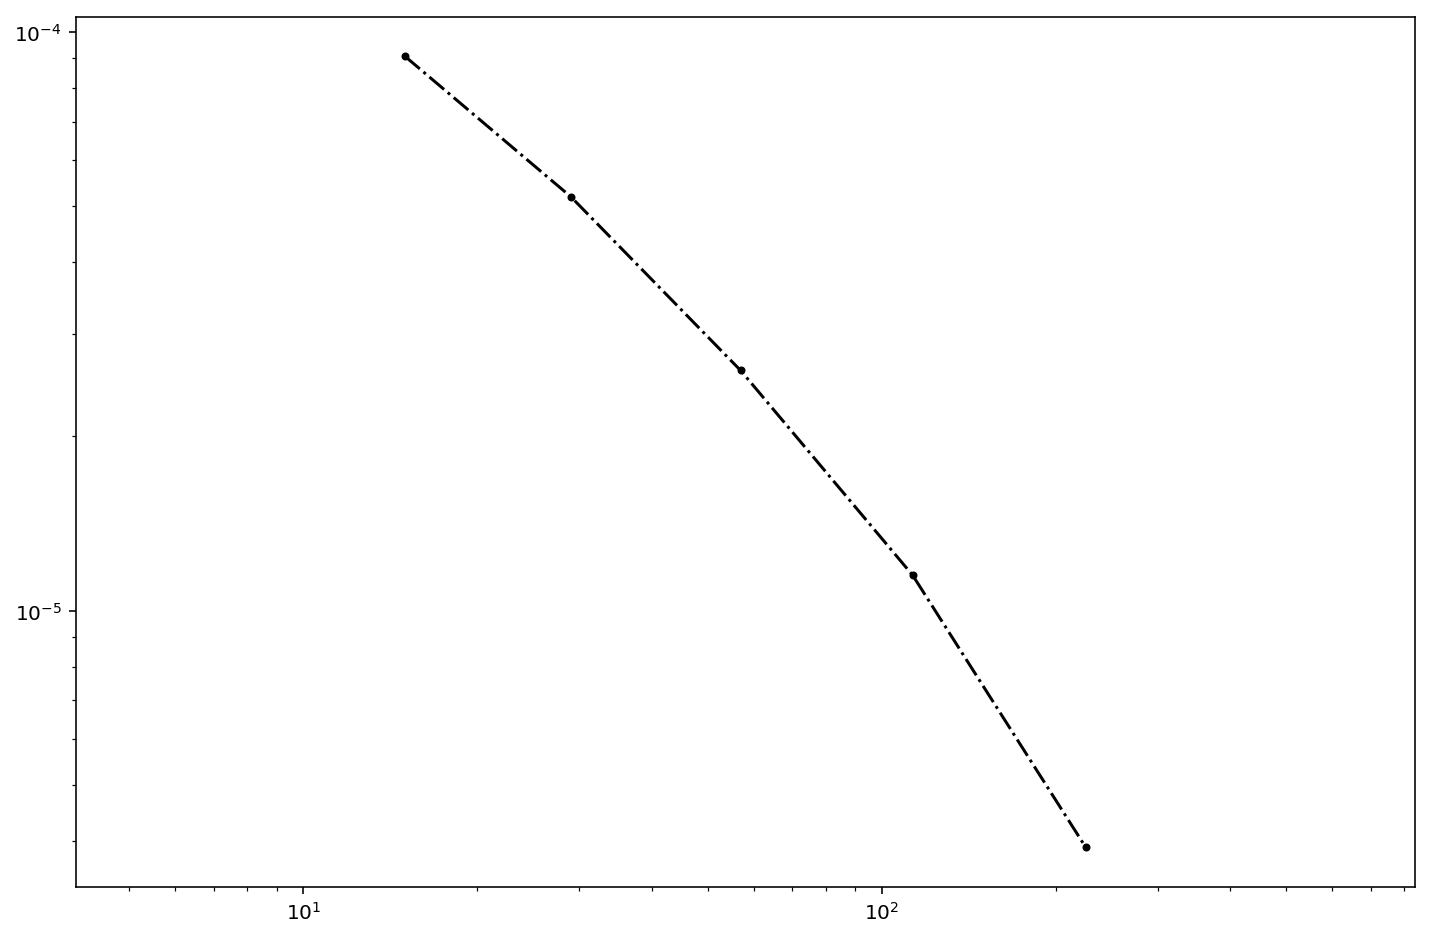

In [12]:
domain_sizes, error = computeError(fbl_filename, averageFD, plot=True)
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())
plt.loglog(domain_sizes, error)
plt.gca().axis('equal')

## Centered in time, centered in space

In [13]:
def benchmarkCTCS(ctcs_filename):
    
    def runCTCS(domain_size):
        #Clean up old simulator if any:
        if 'ctcs_sim' in globals():
            ctcs_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/(nx-1))
        dy = float(height/(ny-1))

        ghosts = [1, 1, 1, 1]
        dataShape = (ny + ghosts[1]+ghosts[3], 
                     nx + ghosts[0]+ghosts[2])

        h0 = np.zeros(dataShape, dtype=np.float32);
        eta0 = np.zeros(dataShape, dtype=np.float32);
        hu0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
        hv0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);
        
        dt = 0.3 * estimateDt(dx, dy, g)
        initH(h0, ghosts)
        initEtaFD(eta0, ghosts)
        initHU(hu0, ghosts)
        initHV(hv0, ghosts)
        A = 0.0

        #Initialize simulator
        ctcs_sim = CTCS.CTCS(gpu_ctx, \
                      h0, eta0, hu0, hv0, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r, A)

        t = ctcs_sim.step(end_time)
        eta1, hu1, hv1 = ctcs_sim.download()
        print("Domain size={:d}, t={:f}, nt={}, eta=[{:f}, {:f}]".format(domain_size, t, ctcs_sim.num_iterations, np.min(eta1), np.max(eta1)))

        return [eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]]
        #return [eta0, hu0, hv0, eta1, hu1, hv1]


    #Run all domain sizes 
    data = {};
    domain_size = domain_min-1
    while (domain_size < domain_max):
        [_, _, _, eta1, _, _] = runCTCS(domain_size)
        data[str(domain_size)] = eta1
        domain_size = domain_size*2-1

    #Save to file
    np.savez_compressed(ctcs_filename, **data)
    
    
ctcs_filename = imgdir + "/CTCS_data.npz"
benchmarkCTCS(ctcs_filename)

Domain size=15, t=5.000000, nt=7, eta=[-0.000000, 0.004338]
Domain size=29, t=5.000000, nt=13, eta=[-0.000000, 0.004182]
Domain size=57, t=5.000000, nt=25, eta=[-0.000000, 0.004145]
Domain size=113, t=5.000000, nt=47, eta=[-0.000000, 0.004136]
Domain size=225, t=5.000000, nt=93, eta=[-0.000000, 0.004133]
Domain size=449, t=5.000000, nt=185, eta=[-0.000000, 0.004133]


(13.100464545240449,
 257.6244520448075,
 7.785666285307864e-08,
 3.345200466441529e-05)

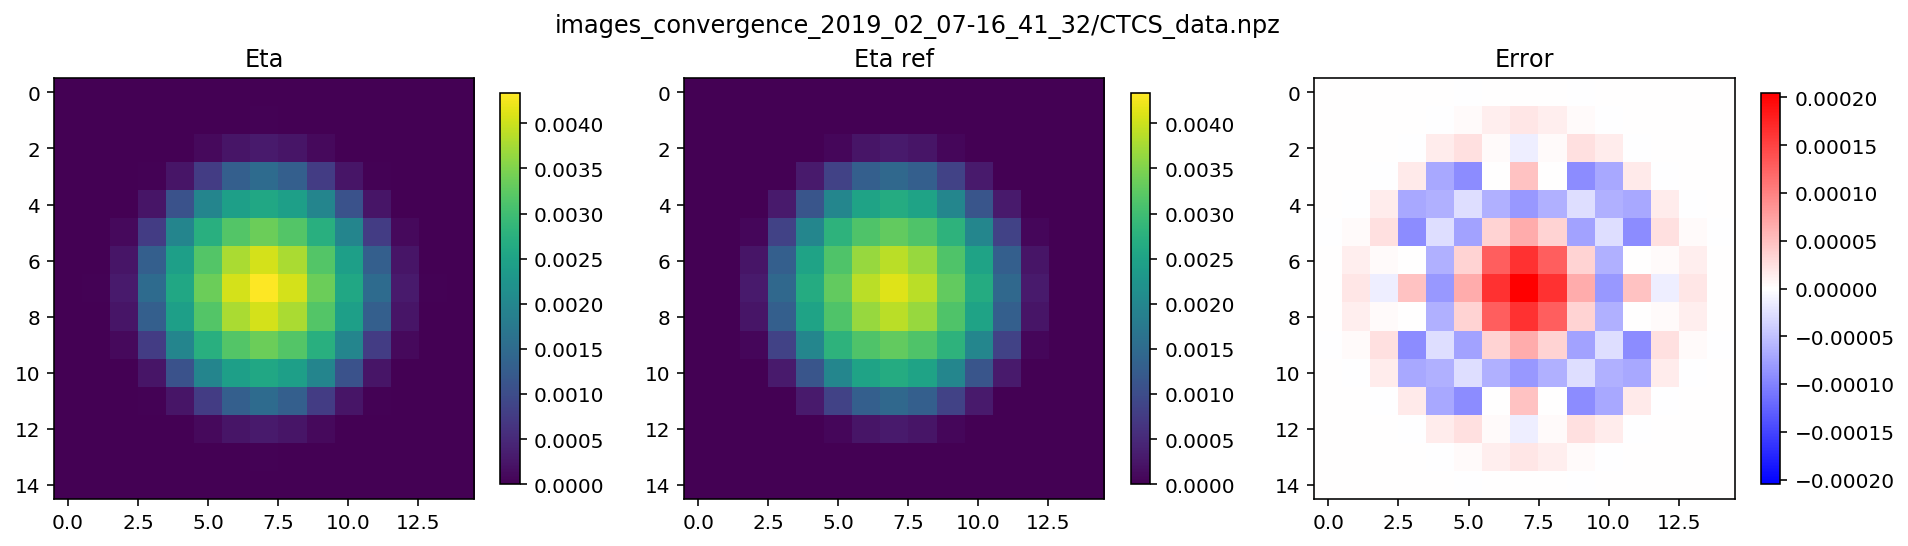

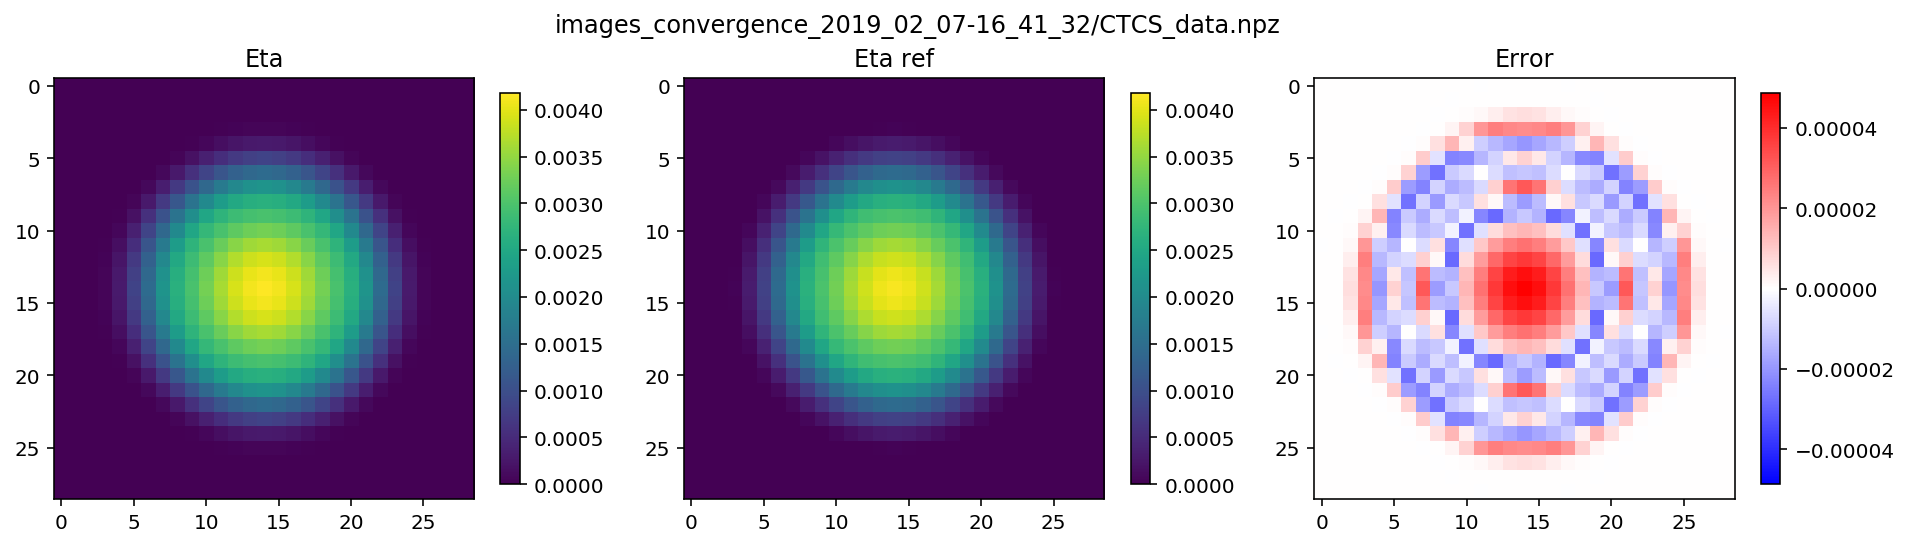

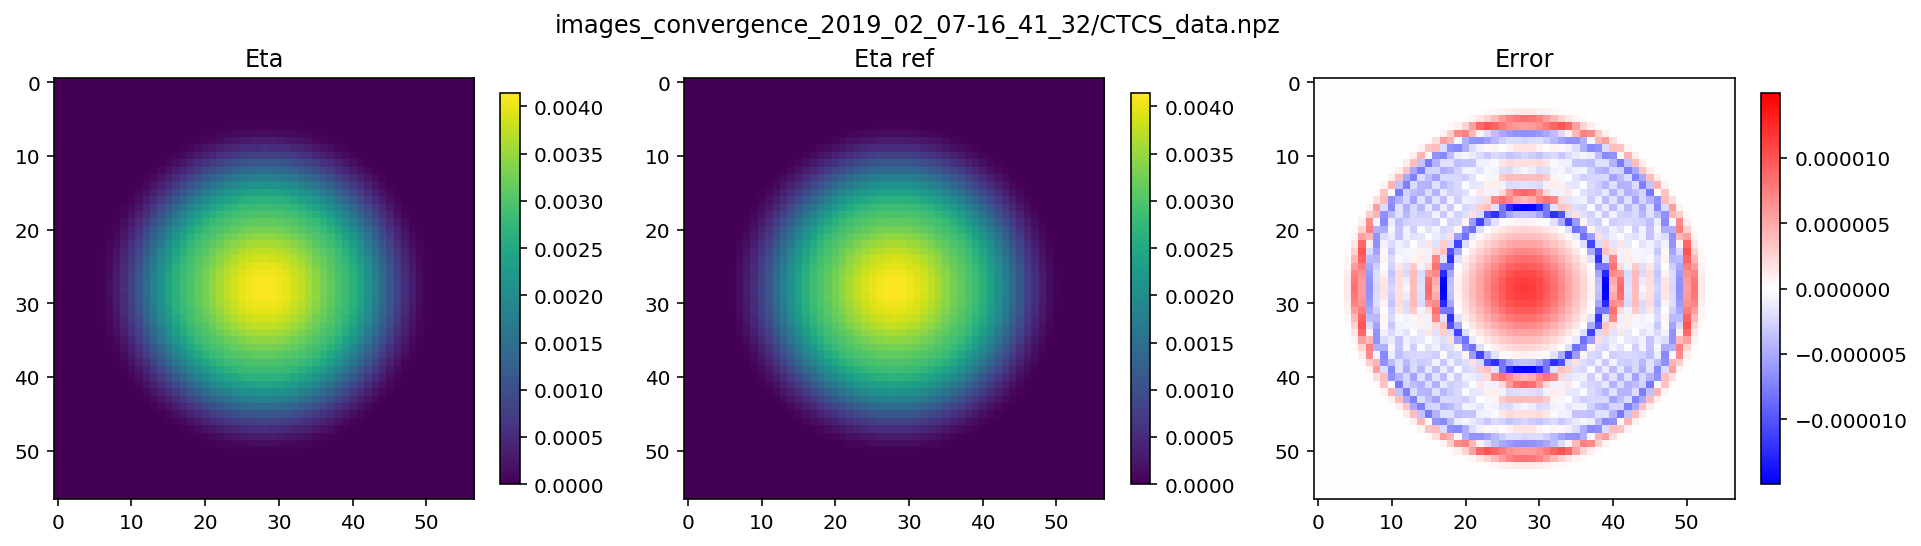

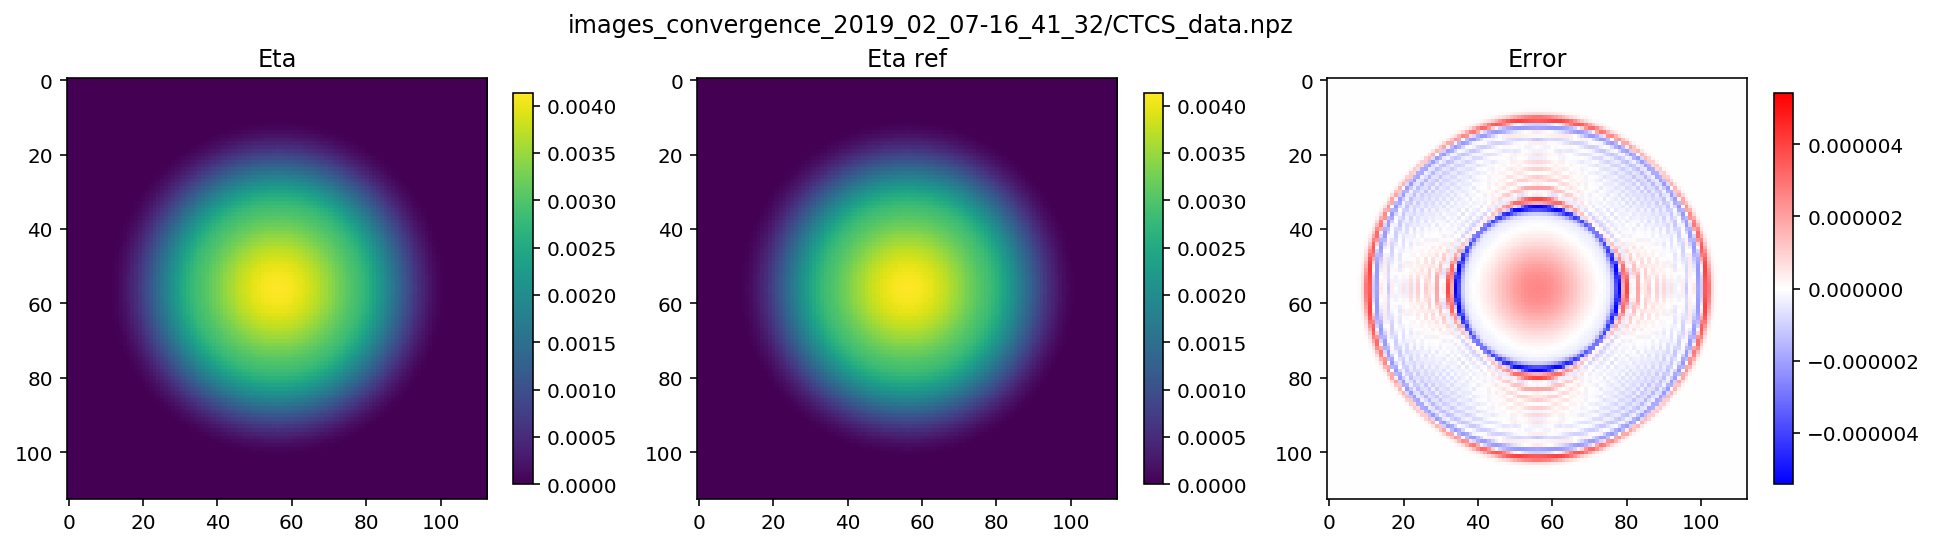

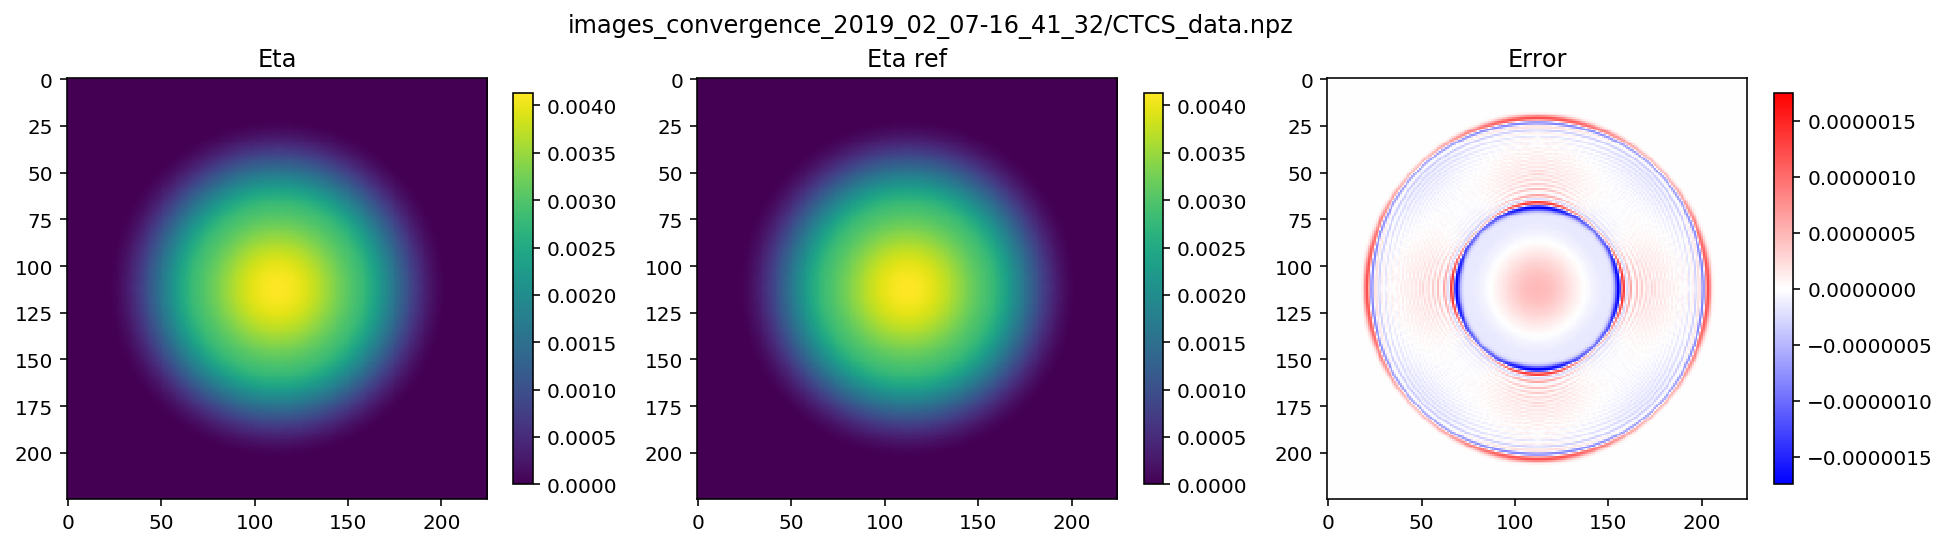

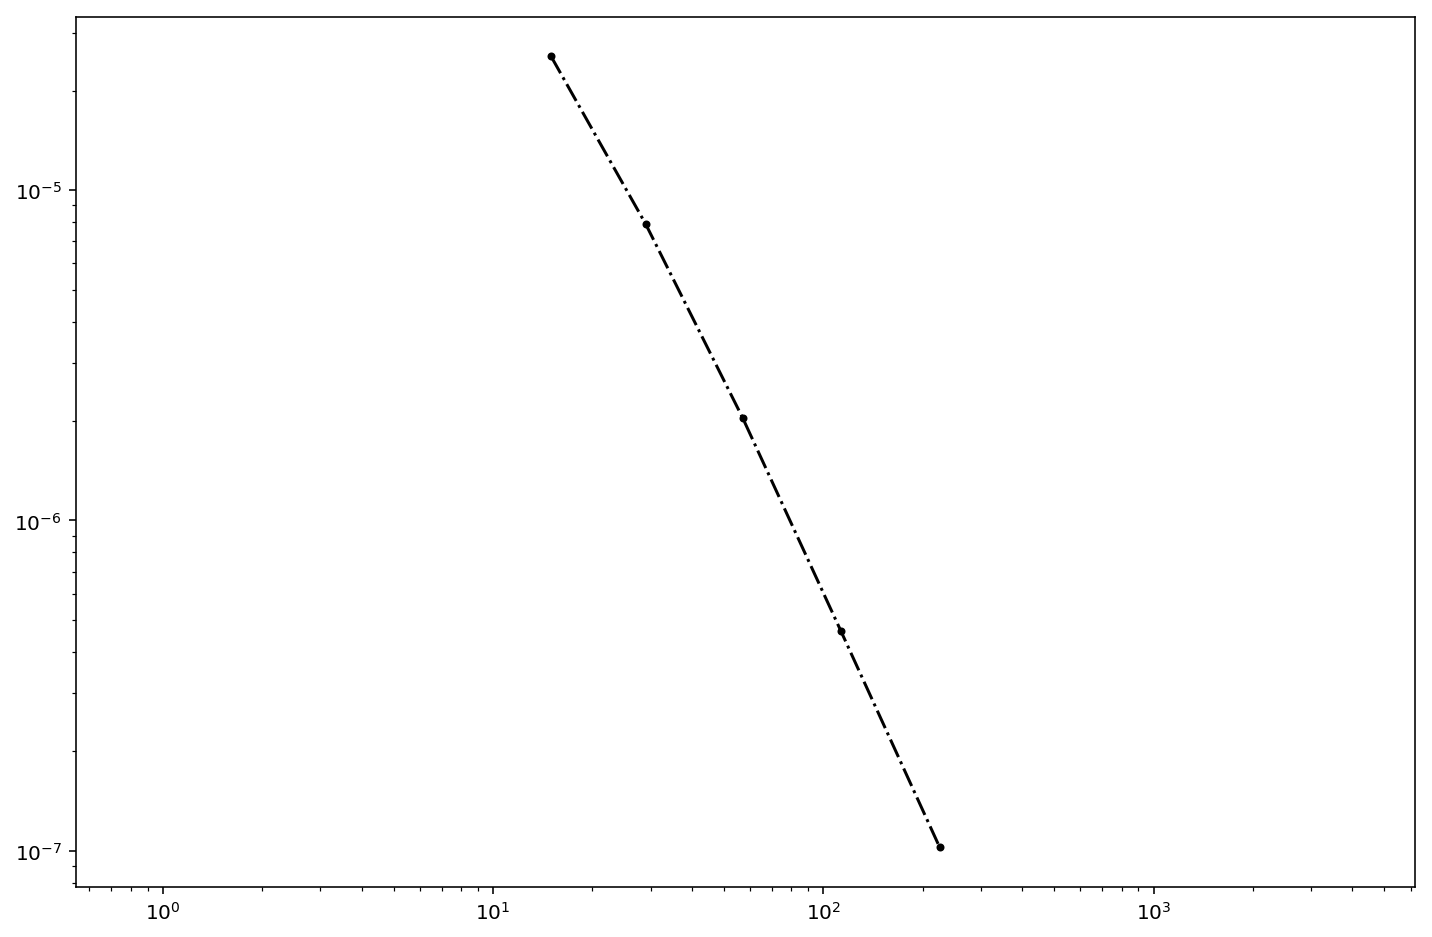

In [14]:
domain_sizes, error = computeError(ctcs_filename, averageFD, plot=True)
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())
plt.loglog(domain_sizes, error)
plt.gca().axis('equal')

## CDKLM 16

In [15]:
def benchmarkCDKLM(cdklm_filename):
    
    def runCDKLM(domain_size, reference_domain_size):
        #Clean up old simulator if any:
        if 'cdklm_sim' in globals():
            cdklm_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/nx)
        dy = float(height/ny)

        ghosts = np.array([2,2,2,2])
        dataShape = (ny + ghosts[1]+ghosts[3], 
                     nx + ghosts[0]+ghosts[2])

        Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)
        eta0 = np.zeros(dataShape, dtype=np.float32);
        hu0 = np.zeros(dataShape, dtype=np.float32);
        hv0 = np.zeros(dataShape, dtype=np.float32);
        
        dt = 0.1 * estimateDt(dx, dy, g)
        initH(Hi, ghosts)
        initEtaFV(eta0, ghosts, reference_domain_size)
        initHU(hu0, ghosts)
        initHV(hv0, ghosts)

        #Initialize simulator
        cdklm_sim = CDKLM16.CDKLM16(gpu_ctx, \
                      eta0, hu0, hv0, Hi, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r)

        t = cdklm_sim.step(end_time)        
        eta1, hu1, hv1 = cdklm_sim.download()
        print("Domain size={:d}, t={:f}, nt={}, eta=[{:f}, {:f}]".format(domain_size, t, cdklm_sim.num_iterations, np.min(eta1), np.max(eta1)))

        return [eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]]
        #return [eta0, hu0, hv0, eta1, hu1, hv1]


    #Run all domain sizes 
    data = {};
    domain_size = domain_min
    
    reference_domain_size = domain_min
    while (reference_domain_size <= domain_max):
        reference_domain_size *= 2
        
    while (domain_size <= domain_max):
        [_, _, _, eta1, _, _] = runCDKLM(domain_size, reference_domain_size)
        data[str(domain_size)] = eta1
        domain_size = domain_size*2

    #Save to file
    np.savez_compressed(cdklm_filename, **data)
    
    
cdklm_filename = imgdir + "/CDKLM_data.npz"
benchmarkCDKLM(cdklm_filename)

Domain size=16, t=5.000000, nt=20, eta=[-0.000000, 0.000376]
Domain size=32, t=5.000000, nt=40, eta=[-0.000000, 0.000414]
Domain size=64, t=5.000000, nt=79, eta=[-0.000000, 0.000420]
Domain size=128, t=5.000000, nt=158, eta=[-0.000000, 0.000422]
Domain size=256, t=5.000000, nt=316, eta=[-0.000000, 0.000422]
Domain size=512, t=5.000000, nt=631, eta=[-0.000000, 0.000422]


(13.928809012737977,
 294.06677887924076,
 1.977225273748152e-08,
 4.687927447622756e-06)

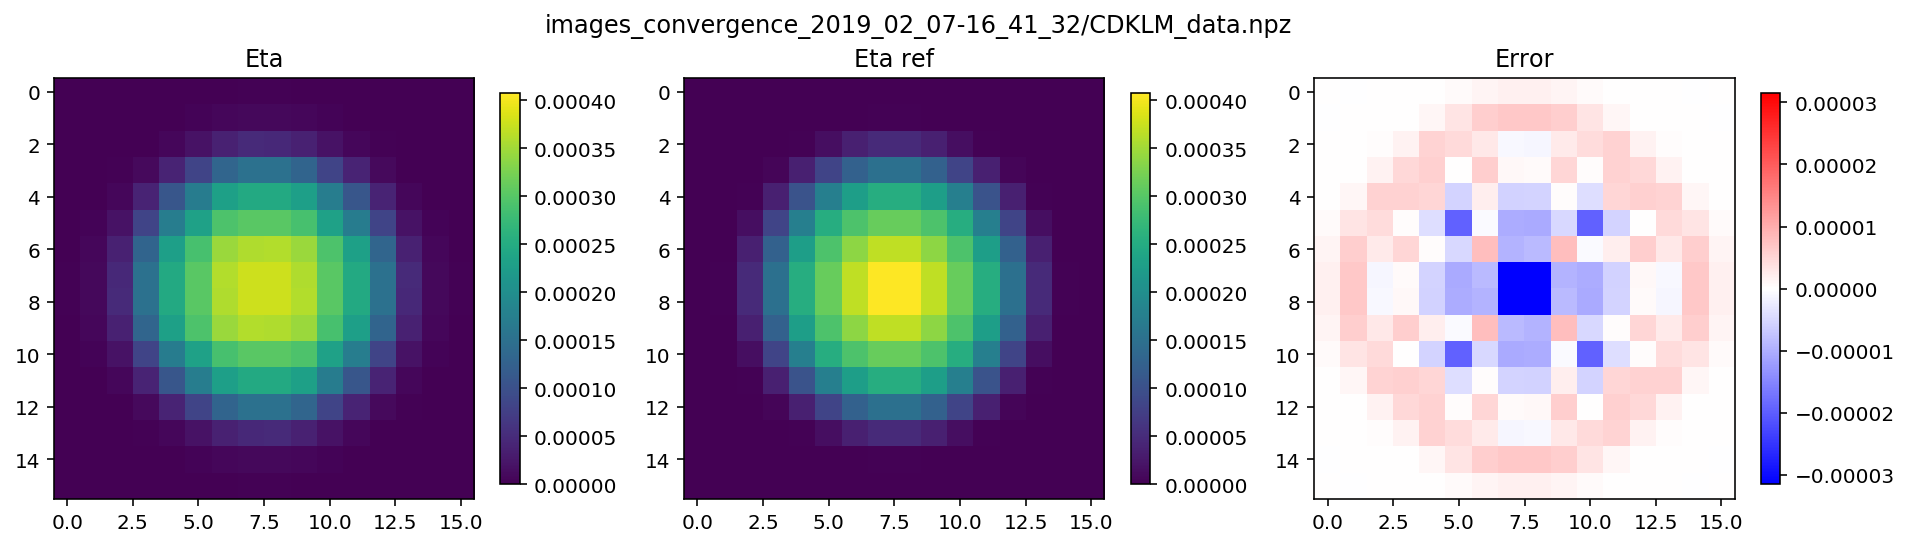

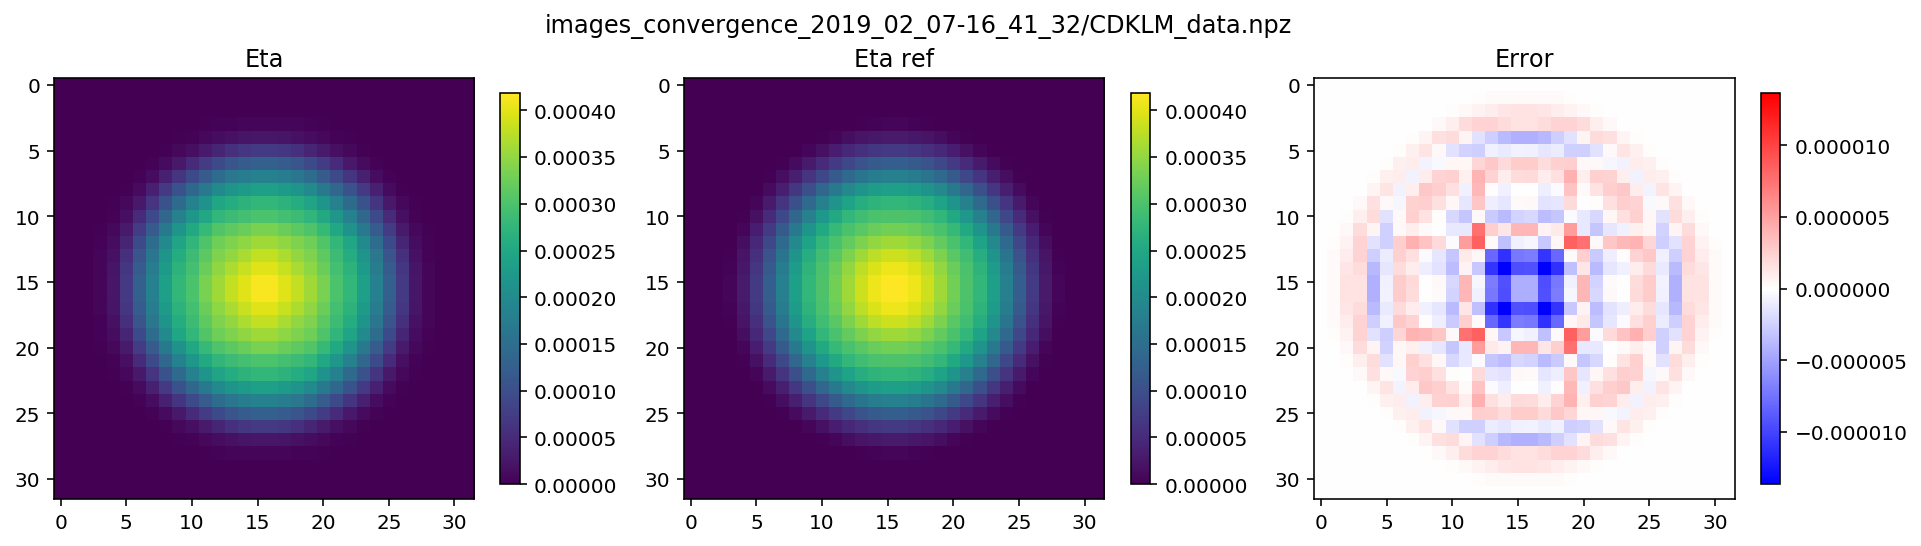

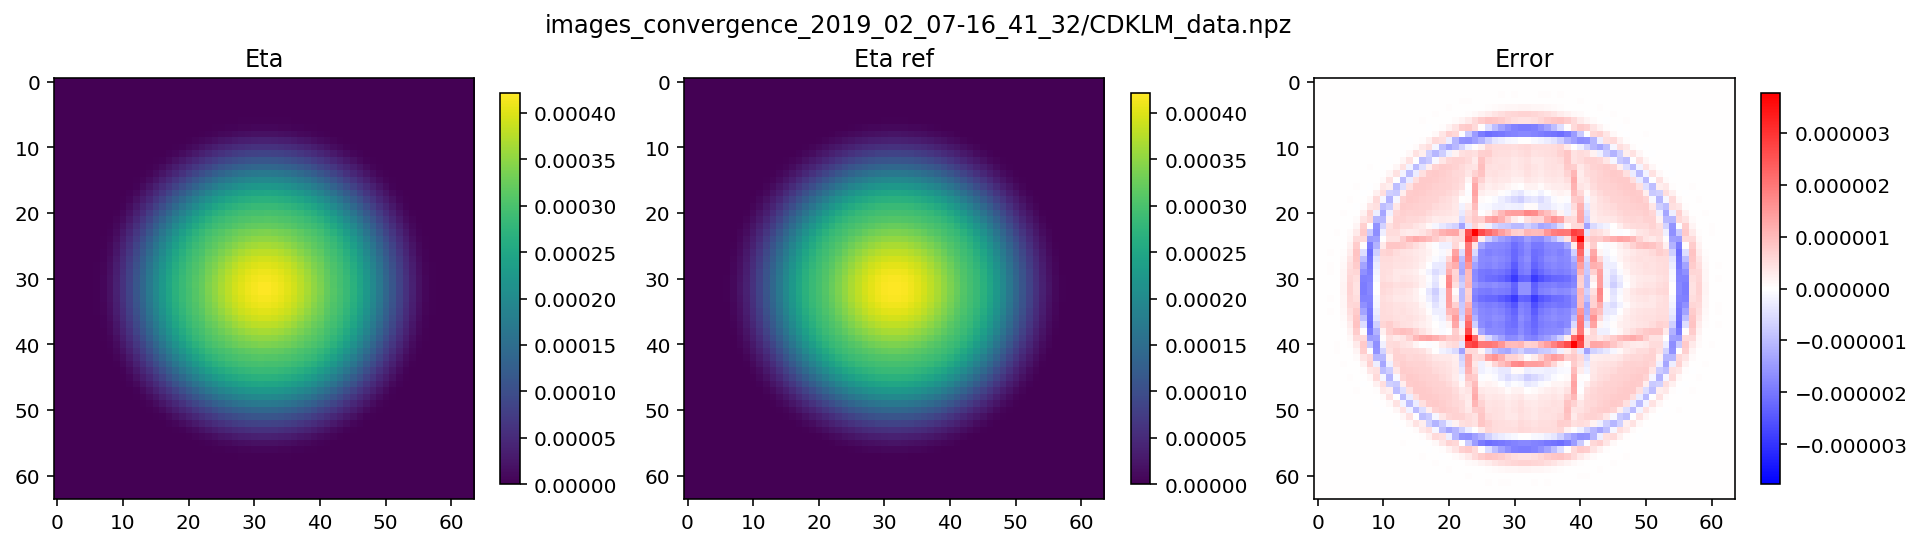

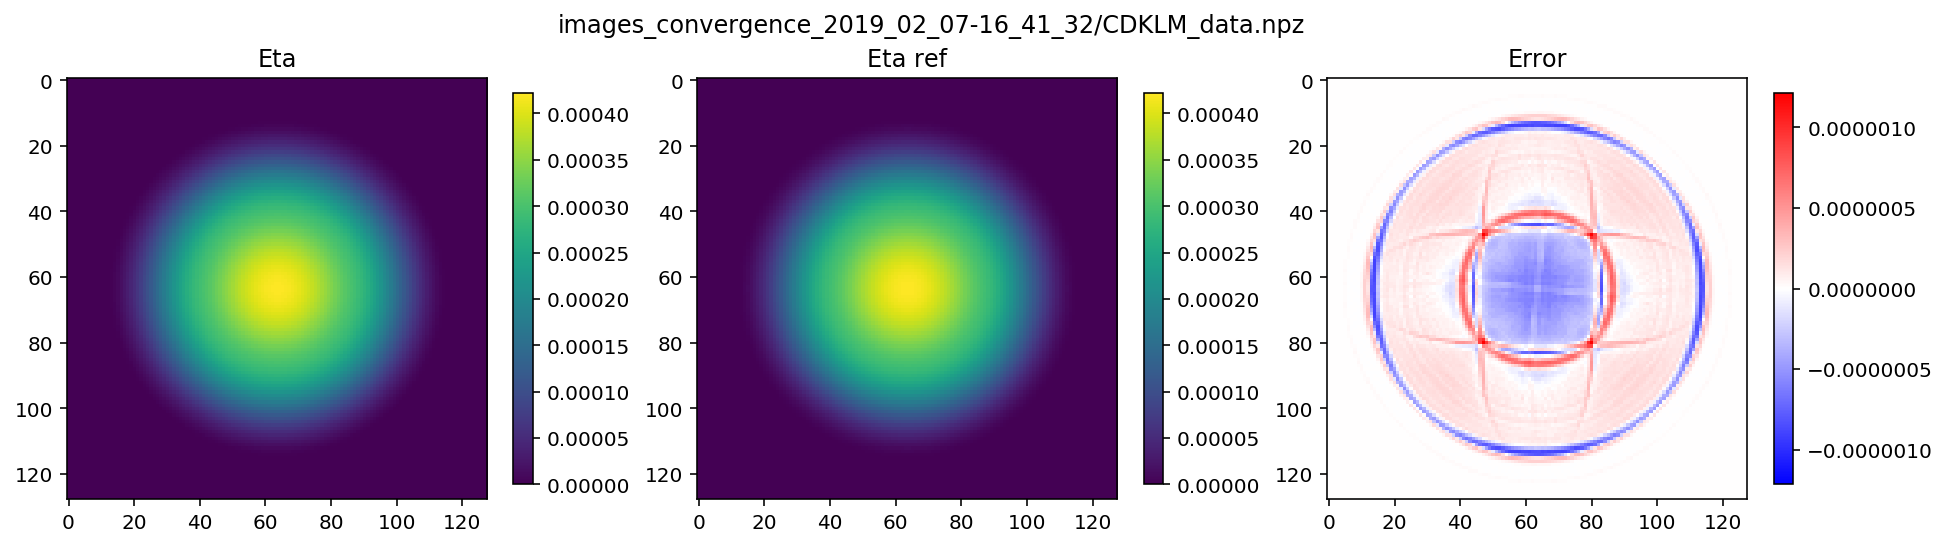

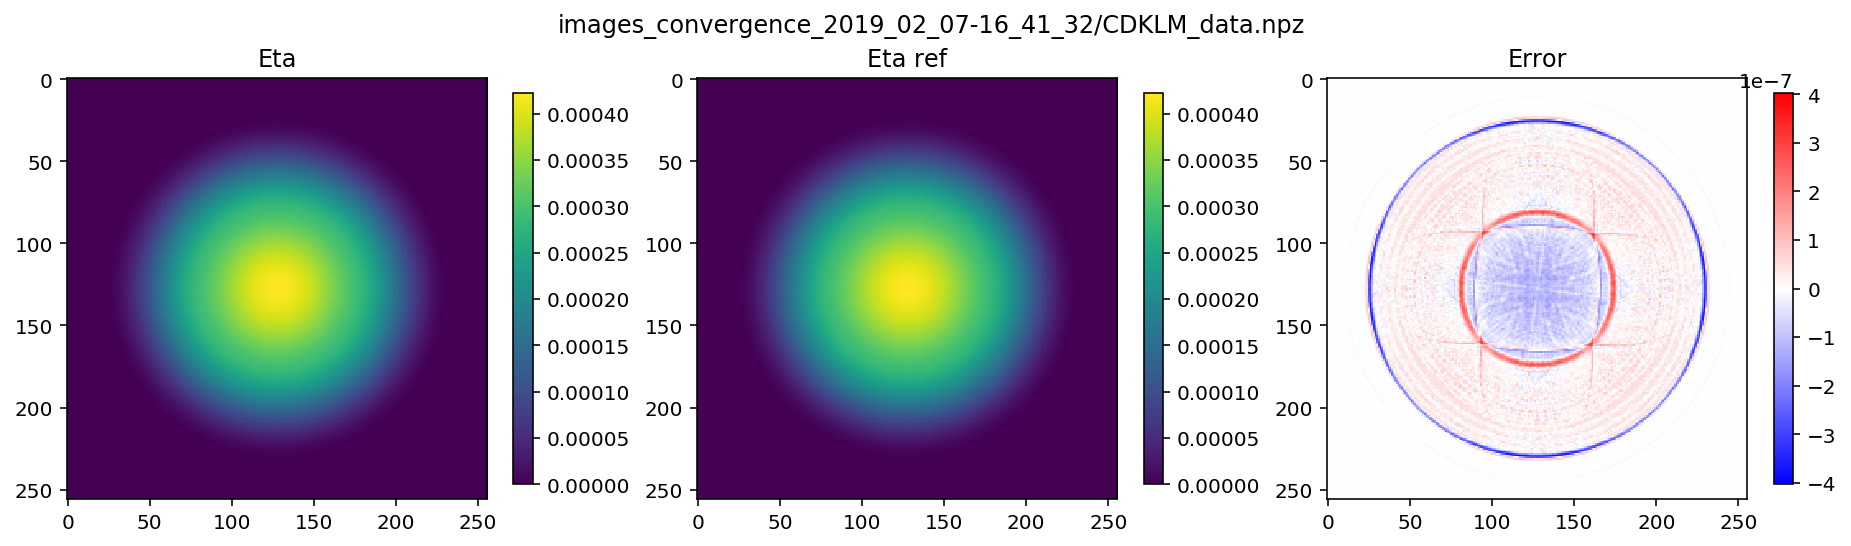

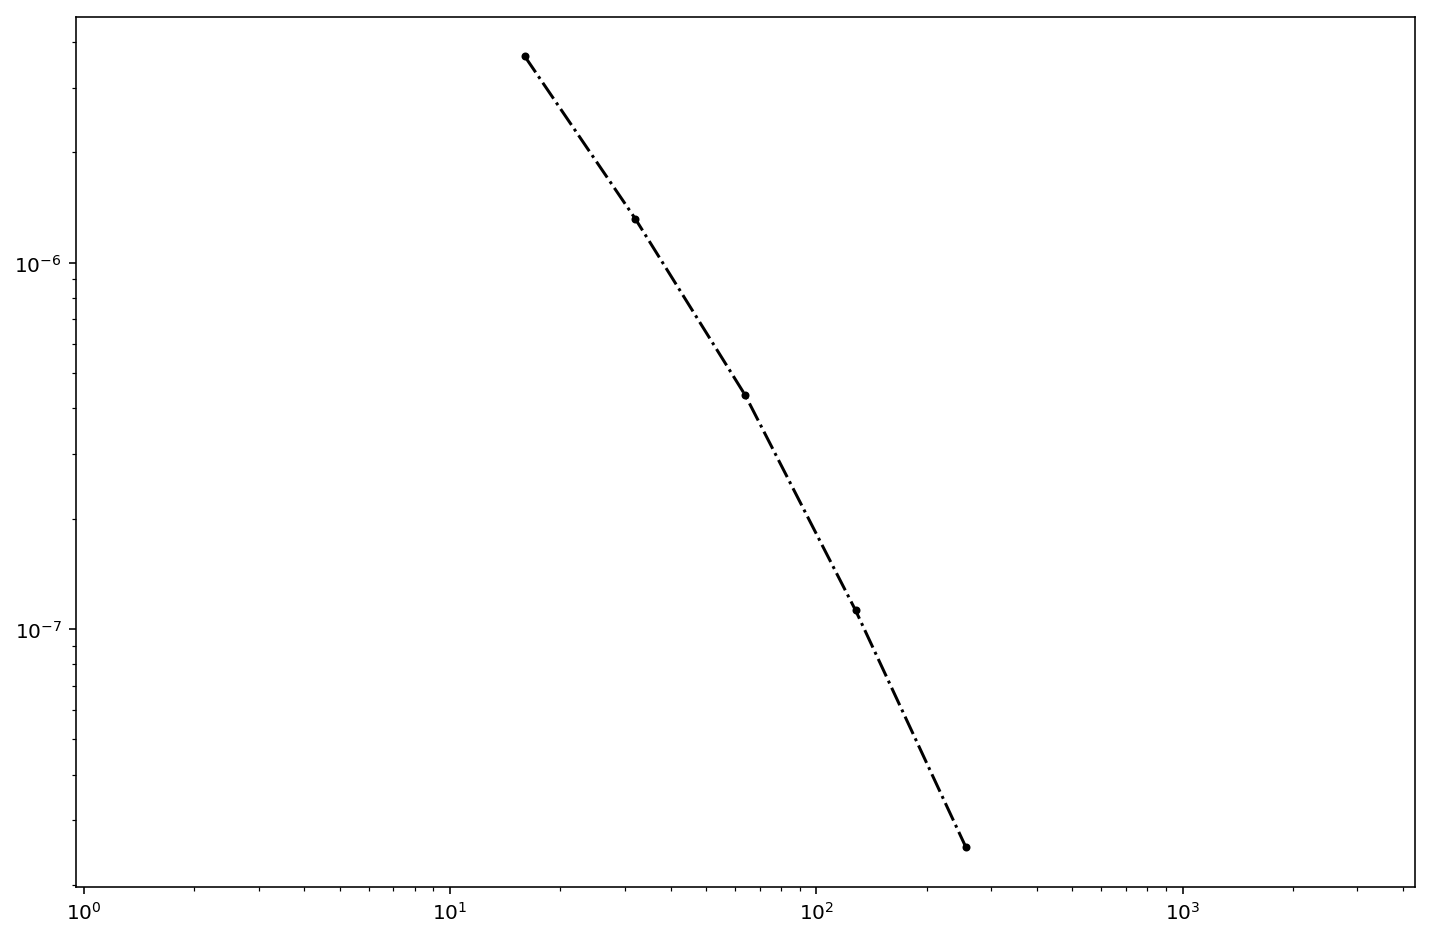

In [16]:
domain_sizes, error = computeError(cdklm_filename, averageFV, plot=True)        
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())
plt.loglog(domain_sizes, error)
plt.gca().axis('equal')

## Kurganov-Petrova 2007

In [17]:
def benchmarkKP07(cdklm_filename):
    
    def runKP07(domain_size, reference_domain_size):
        #Clean up old simulator if any:
        if 'kp07_sim' in globals():
            kp07_sim.cleanUp()

        nx = domain_size
        ny = domain_size

        dx = float(width/nx)
        dy = float(height/ny)

        ghosts = np.array([2,2,2,2])
        dataShape = (ny + ghosts[1]+ghosts[3], 
                     nx + ghosts[0]+ghosts[2])

        Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)
        eta0 = np.zeros(dataShape, dtype=np.float32);
        hu0 = np.zeros(dataShape, dtype=np.float32);
        hv0 = np.zeros(dataShape, dtype=np.float32);
        
        dt = 0.1 * estimateDt(dx, dy, g)
        initH(Hi, ghosts)
        initEtaFV(eta0, ghosts, reference_domain_size)
        initHU(hu0, ghosts)
        initHV(hv0, ghosts)

        #Initialize simulator
        kp07_sim = KP07.KP07(gpu_ctx, \
                      eta0, Hi, hu0, hv0, \
                      nx, ny, \
                      dx, dy, dt, \
                      g, f, r)

        t = kp07_sim.step(end_time)
        eta1, hu1, hv1 = kp07_sim.download()
        print("Domain size={:d}, t={:f}, nt={}, eta=[{:f}, {:f}]".format(domain_size, t, kp07_sim.num_iterations, np.min(eta1), np.max(eta1)))

        return [eta0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv0[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                eta1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hu1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]], 
                hv1[ghosts[1]:-ghosts[3], ghosts[0]:-ghosts[2]]]
        #return [eta0, hu0, hv0, eta1, hu1, hv1]


    #Run all domain sizes 
    data = {};
    domain_size = domain_min
    
    reference_domain_size = domain_min
    while (reference_domain_size <= domain_max):
        reference_domain_size *= 2
        
    while (domain_size <= domain_max):
        [_, _, _, eta1, _, _] = runKP07(domain_size, reference_domain_size)
        data[str(domain_size)] = eta1
        domain_size = domain_size*2

    #Save to file
    np.savez_compressed(kp07_filename, **data)
    
    
kp07_filename = imgdir + "/KP07_data.npz"
benchmarkKP07(kp07_filename)

Domain size=16, t=5.000000, nt=20, eta=[0.000000, 0.000381]
Domain size=32, t=5.000000, nt=40, eta=[0.000000, 0.000416]
Domain size=64, t=5.000000, nt=79, eta=[0.000000, 0.000420]
Domain size=128, t=5.000000, nt=158, eta=[0.000000, 0.000422]
Domain size=256, t=5.000000, nt=316, eta=[0.000000, 0.000422]
Domain size=512, t=5.000000, nt=631, eta=[0.000000, 0.000423]


(13.928809012737977,
 294.06677887924076,
 1.840640961622258e-08,
 5.00078950367561e-06)

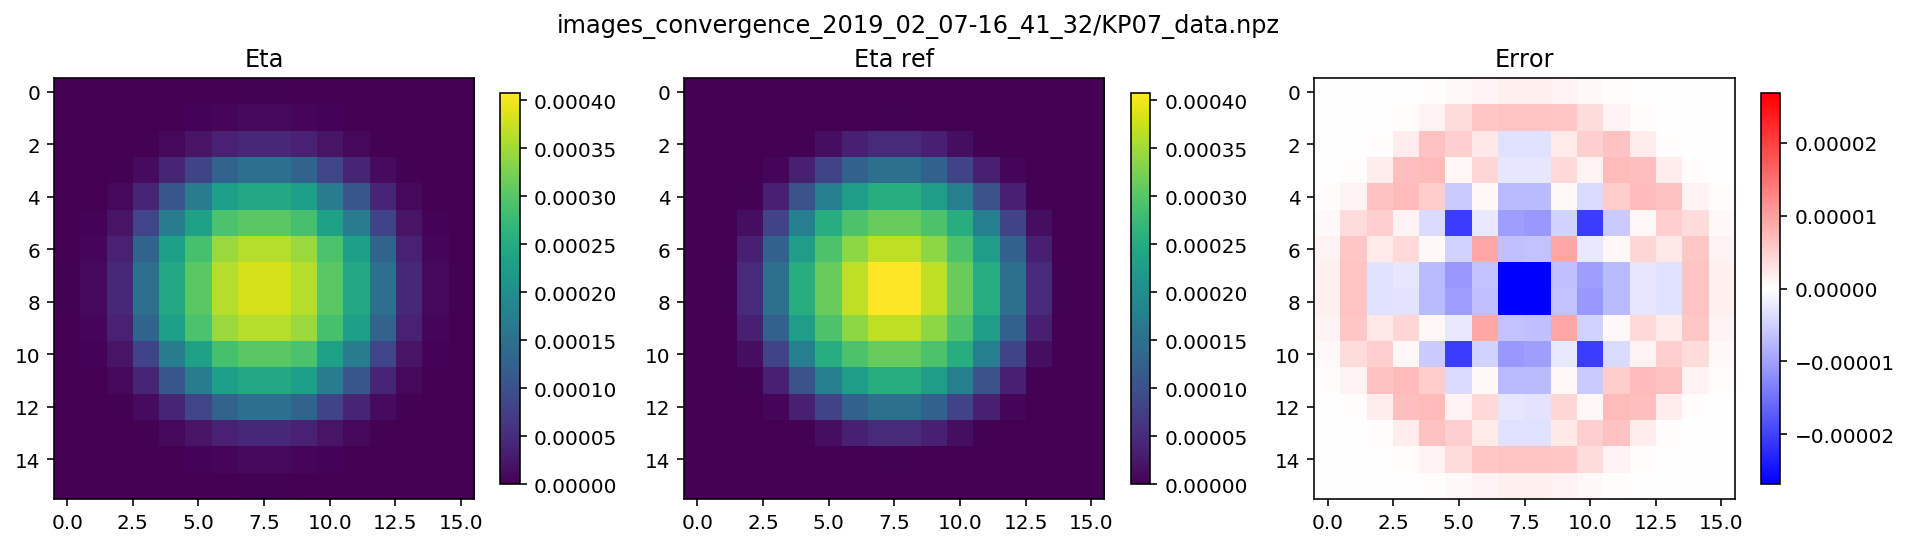

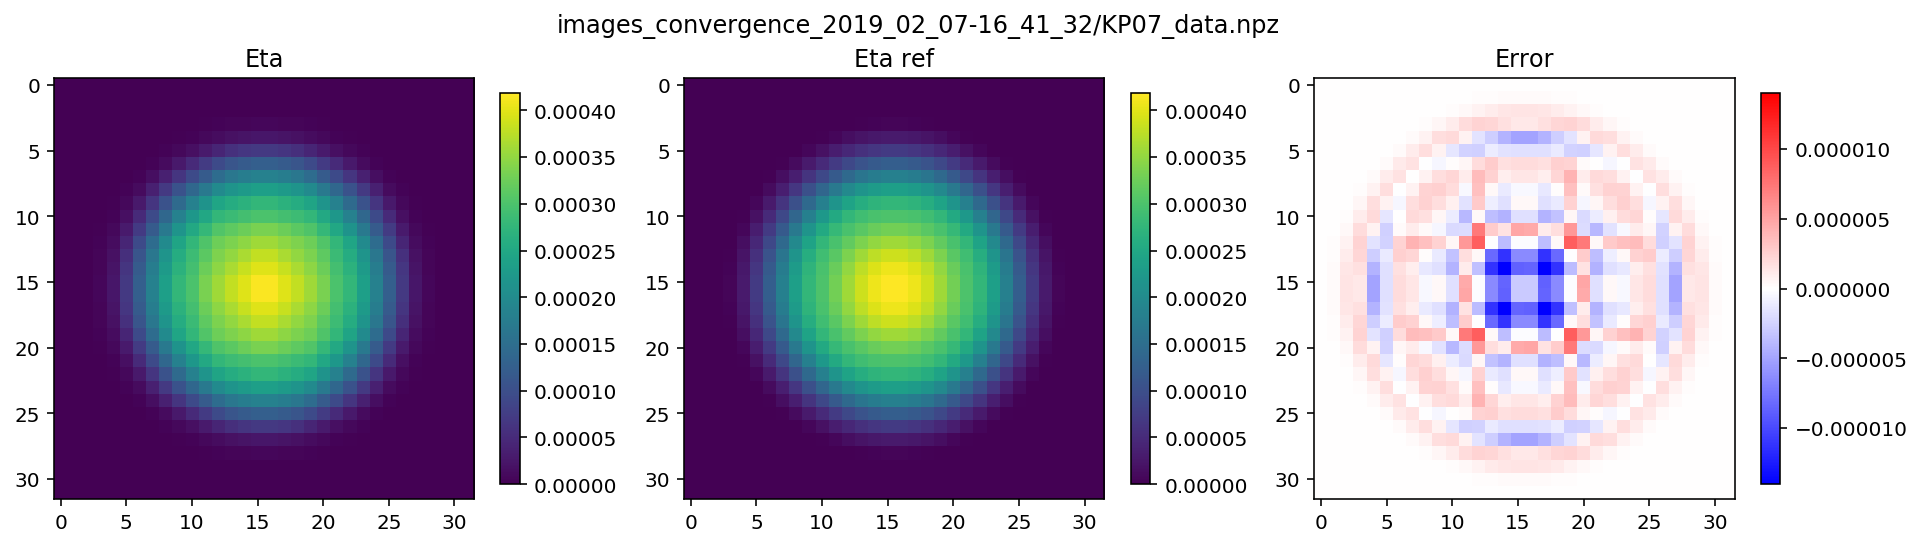

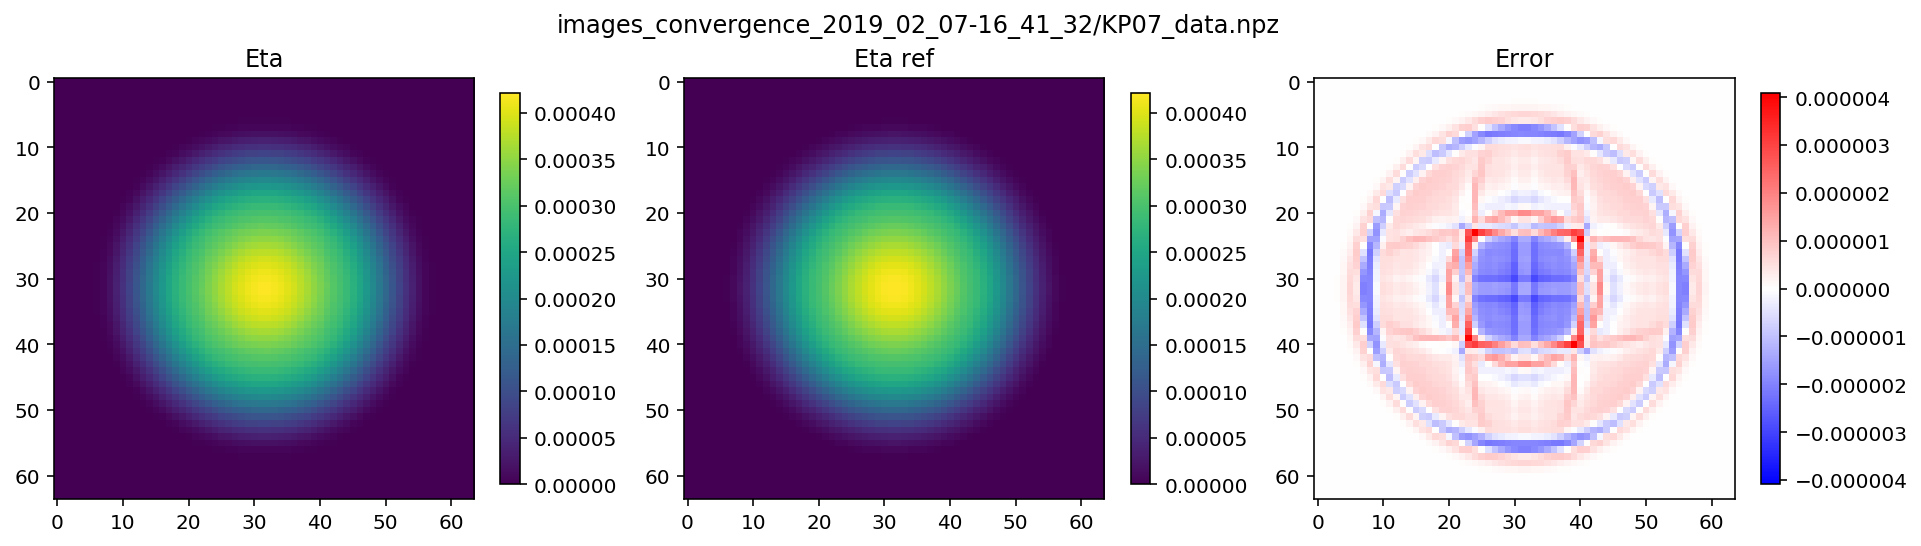

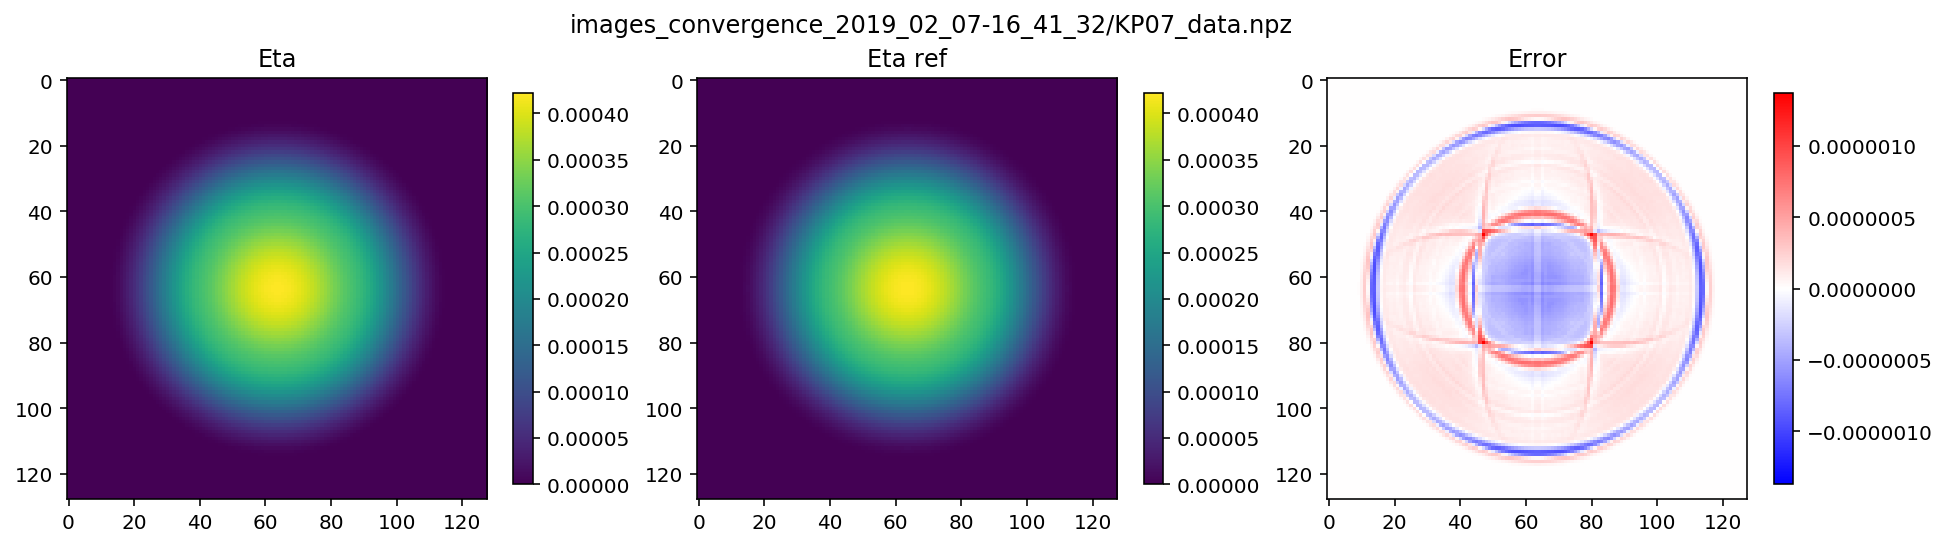

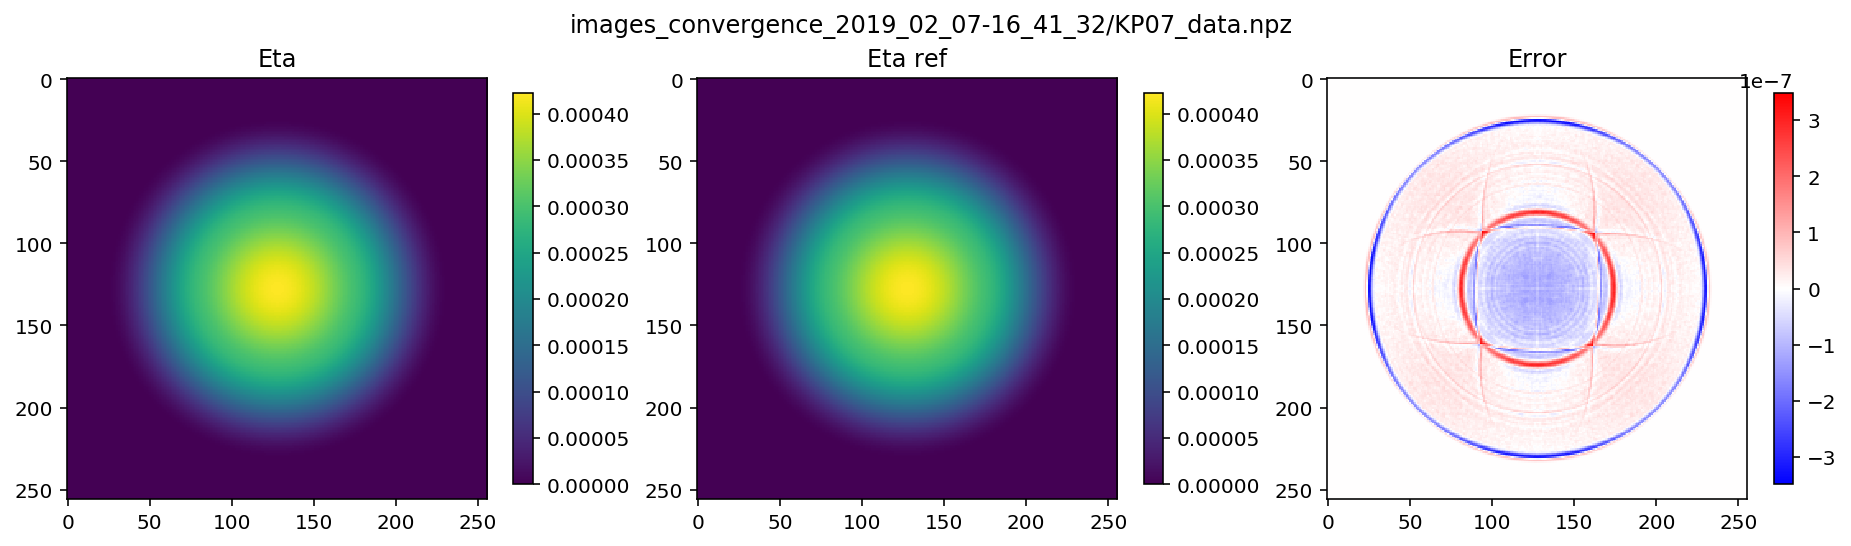

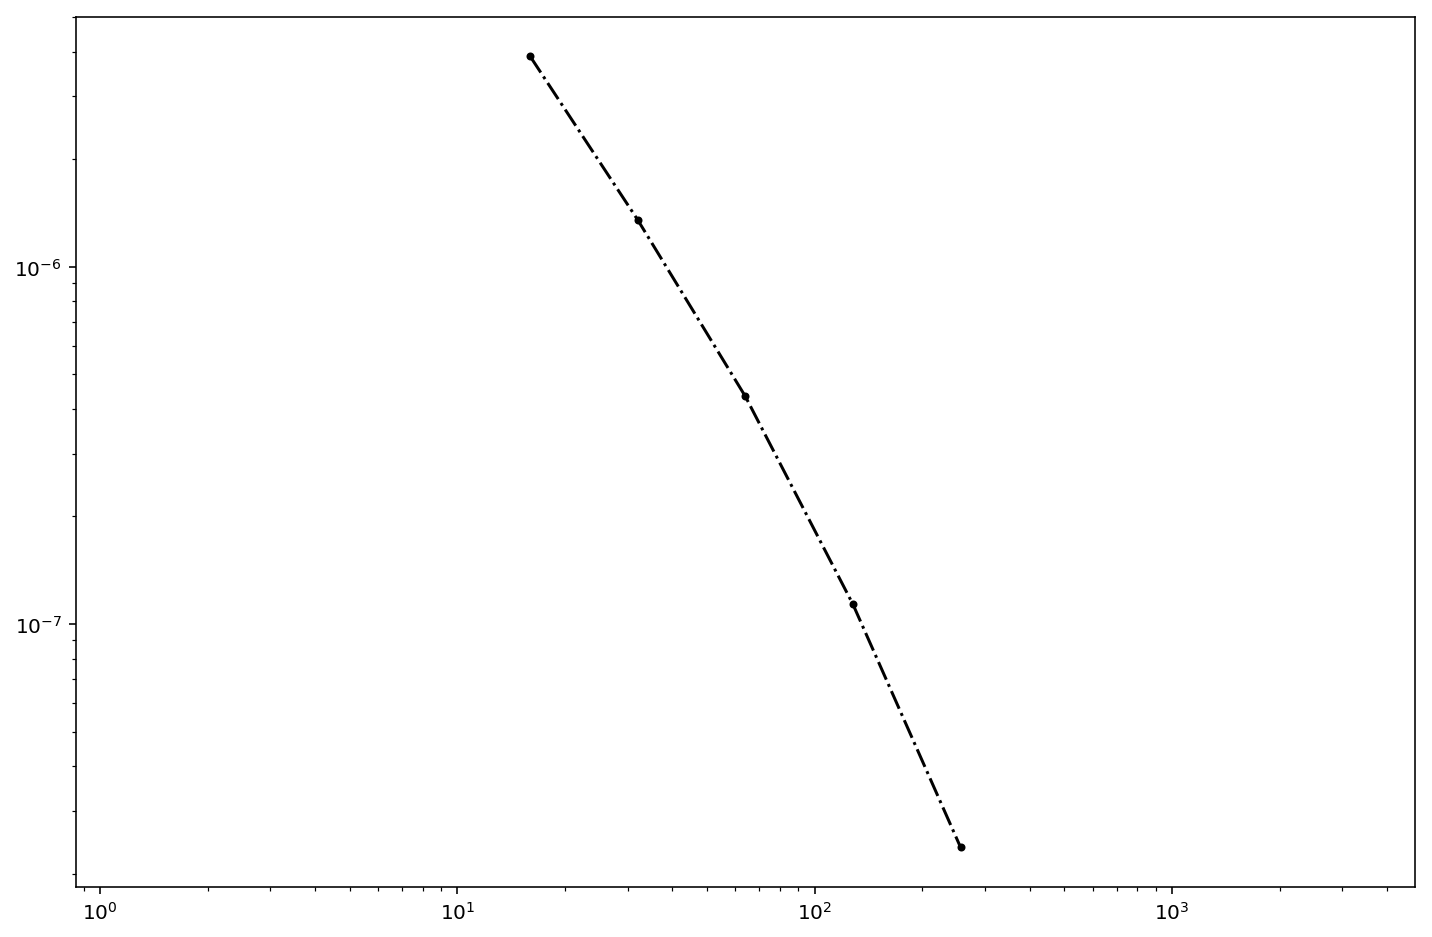

In [18]:
domain_sizes, error = computeError(kp07_filename, averageFV, plot=True)        
fig = plt.figure(figsize=(12, 8))
setBwStyles(fig.gca())
plt.loglog(domain_sizes, error)
plt.gca().axis('equal')

[0.84668879 1.02313272 1.19029493 1.57184818]
[1.7722248  1.99894084 2.16961773 2.1895064 ]
[1.52071673 1.63986898 1.93234931 2.25779573]
[1.46978797 1.60508921 1.94996199 2.14727826]
------ order 1 ----------
FBL: 1.106713824333895
CTCS: 2.0842792864328494
KP07: 1.786109144006933
CDKLM: 1.777525599773793
x_order_1:  1.0
x_order_2:  2.0
[0.88182722 1.02842543 1.19345214 1.57270379]
[1.94279264 1.92183613 1.93120833 2.00998643]
[1.30832617 1.70906114 1.83026632 2.0552448 ]
[1.36597876 1.70575502 1.83790711 1.98196184]
------ order 2 ----------
FBL: 1.1109387828201713
CTCS: 1.9370004842318358
KP07: 1.7696637307363525
CDKLM: 1.7718310685108576
x_order_1:  1.0
x_order_2:  2.0
[0.92687014 1.0505355  1.20590398 1.57918952]
[2.1772056  1.74744381 1.48332179 1.64468057]
[0.93535055 1.77862011 1.57555254 1.97781914]
[1.20924316 1.85466444 1.63451947 1.5913959 ]
------ order inf ----------
FBL: 1.1282197382225425
CTCS: 1.6960621912237084
KP07: 1.677086322140357
CDKLM: 1.6129576858789696
x_order_

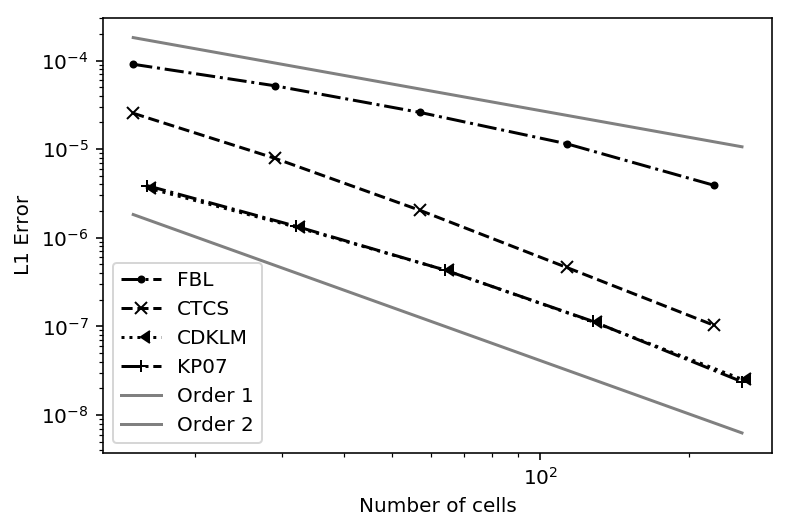

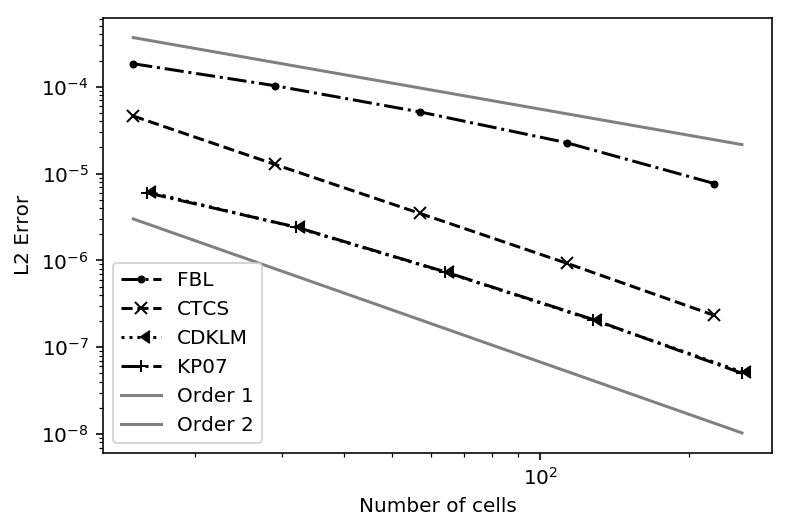

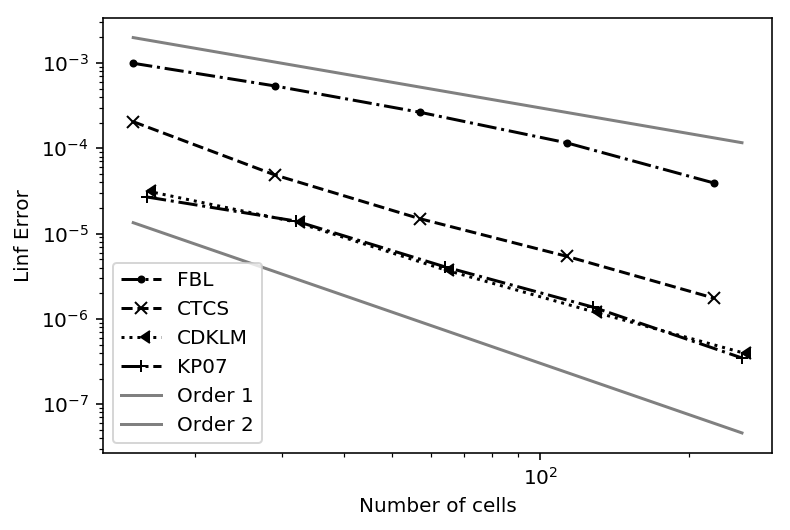

In [40]:
def find_numerical_order(data):
    #return -np.log(data[1][-1] / data[1][-2]) / np.log(data[0][-1] / data[0][-2]) 
    
    
    num_intervals = len(data[0])-1
    order = np.empty(num_intervals)
    for i in range(num_intervals):
        x0 = data[0][i]
        x1 = data[0][i+1]
        y0 = data[1][i]
        y1 = data[1][i+1]
    
        order[i] = -np.log(y1/y0) / np.log(x1/x0)
        
    return np.median(np.array(order))


for order in [1, 2, np.inf]:
    fbl_data = computeError(fbl_filename, averageFD, order=order)
    ctcs_data = computeError(ctcs_filename, averageFD, order=order)
    cdklm_data = computeError(cdklm_filename, averageFV, order=order)
    kp07_data = computeError(kp07_filename, averageFV, order=order)

    fig = plt.figure()
    setBwStyles(fig.gca())
    plt.loglog(fbl_data[0], fbl_data[1], label='FBL')
    plt.loglog(ctcs_data[0], ctcs_data[1], label='CTCS')
    plt.loglog(cdklm_data[0], cdklm_data[1], label='CDKLM')
    plt.loglog(kp07_data[0], kp07_data[1], label='KP07')
    
    fbl_order   = find_numerical_order(fbl_data)
    ctcs_order  = find_numerical_order(ctcs_data)
    kp_order    = find_numerical_order(kp07_data)
    cdklm_order = find_numerical_order(cdklm_data)
    
    print("------ order " + str(order) + " ----------")
    print("FBL: " + str(fbl_order))
    print("CTCS: " + str(ctcs_order))
    print("KP07: " + str(kp_order))
    print("CDKLM: " + str(cdklm_order))

    #plt.gca().axis('equal')

    min_x = np.min([fbl_data[0][0], ctcs_data[0][0], cdklm_data[0][0], kp07_data[0][0]])
    max_x = np.max([fbl_data[0][-1], ctcs_data[0][-1], cdklm_data[0][-1], kp07_data[0][-1]])
    min_scale = np.min([fbl_data[1][0], ctcs_data[1][0], cdklm_data[1][0], kp07_data[1][0]]) * min_x * min_x * 0.5
    max_scale = np.max([fbl_data[1][0], ctcs_data[1][0], cdklm_data[1][0], kp07_data[1][0]]) * min_x * 2
    x = np.linspace(min_x, max_x, 4)
    plt.loglog(x, max_scale/x, '-', color='gray', label='Order 1')
    plt.loglog(x, min_scale/(x*x), '-', color='gray', label='Order 2')

    plt.legend()

    plt.xlabel("Number of cells")
    plt.ylabel("L" + str(order) + " Error")

    plt.savefig(imgdir + "/convergence" + str(order) + ".pdf")
    
    
    x_order_1 = -np.log((max_scale/x[-1])/(max_scale/x[0])) / (np.log(x[-1]/x[0])) 
    x_order_2 = -np.log((max_scale/(x[-1]*x[-1]))/(max_scale/(x[0]*x[0]))) / (np.log(x[-1]/x[0])) 
    print("x_order_1: ", x_order_1)
    print("x_order_2: ", x_order_2)
    

In [20]:
print(imgdir)

images_convergence_2019_02_07-16_41_32
